In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import utils as u

In [2]:
GG_files_suf = ['__talking_against_wall', 
                      '__outside_talking_still_laughing', 
                      '__talking_angry_couch',
                      '__podium_speech_happy', 
                      '__outside_talking_pan_laughing',
                      '__kitchen_pan',
                      '__kitchen_still']


# get all the identity specific train and test files for all available dataset
def get_files_per_dataset(bs_fldr):
    
    dataset = {}
    
    dataset['LDR'] = {}
    dataset['LDR']['real'] = {}
    for k in ['bo', 'bs', 'ew', 'dt', 'hc', 'jb', 'kh', 'br', 'pb', 'cb', 
              'bo_imposter', 'bs_imposter', 'ew_imposter', 
              'dt_imposter', 'hc_imposter', 'jb_imposter']:   # imposter videos
        dataset['LDR']['real'][k] = u.load_file_names(bs_fldr, k, join_bsfldr=False)
    #FAKE: Leaders
    dataset['LDR']['fake'] = {}
    fake_name = ['bo_faceswap', 'bs_faceswap', 'ew_faceswap', 'dt_faceswap', 'hc_faceswap', 'jb_faceswap']
    lbl = ['bo', 'bs', 'ew', 'dt', 'hc', 'jb']
    for i in range(len(lbl)):
        dataset['LDR']['fake'][lbl[i]] = u.load_file_names(bs_fldr, fake_name[i], join_bsfldr=False)
        
    
    # Face-Forensics
    dataset['FF'] = {}
    dataset['FF']['real'] = {}
    ff_orig_files = u.load_file_names(bs_fldr, 'FF_orig', join_bsfldr=False)
    for k in range(1000):
        cur_name = '{0:03d}'.format(k)
        df = [f for f in ff_orig_files if cur_name + '.npy' in f]
        if len(df)>0:
            dataset['FF']['real']['FF_'+cur_name] = df
    #FAKE: FaceForensics
    dataset['FF']['fake'] = {}
    for ff_fldr in ['FF_Deepfakes', 'FF_FaceSwap']:            
        ff_files = u.load_file_names(bs_fldr, ff_fldr, join_bsfldr=False)
        for k in range(1000):
            cur_name = '{0:03d}'.format(k)
            df = [f for f in ff_files if cur_name + '.npy' in f]
            if len(df)>0:            
                if 'FF_'+cur_name not in list(dataset['FF']['fake'].keys()):
                    dataset['FF']['fake']['FF_'+cur_name] = df
                else:
                    dataset['FF']['fake']['FF_'+cur_name] = dataset['FF']['fake']['FF_'+cur_name] + df
                
    # DFD
    dataset['GG'] = {}
    dataset['GG']['real'] = {}
    dataset['GG']['fake'] = {}
    
    GG_orig_allfiles = u.load_file_names(bs_fldr, 'GG_orig', join_bsfldr=False)
    GG_fake_allfiles = u.load_file_names(bs_fldr, 'GG_fake', join_bsfldr=False)
    id_lbl = np.unique([f.split('/')[-1][:2] for f in GG_orig_allfiles])  # get the unique ids
    for k in id_lbl:
        
        #real Train
        orig_files = [f for f in GG_orig_allfiles if f.split('/')[-1][:2]==k and 
                      np.any([x in f for x in GG_files_suf])] # current file label        
        dataset['GG']['real']['GG_'+k] = orig_files.copy()
        
        #fake
        fake_files = [f for f in GG_fake_allfiles if (f'_{k}_' in f.split('/')[-1][2:]) 
                      and np.any([x in f for x in GG_files_suf])] # current file label
        dataset['GG']['fake']['GG_'+k] = fake_files.copy()
        
        
    # DFDC
    dataset['DFDC'] = {}
    dataset['DFDC']['real'] = {}
    dataset['DFDC']['fake'] = {}
    
    DFDC_orig_allfiles = u.load_file_names(bs_fldr, 'DFDC_orig', join_bsfldr=False)
    DFDC_fake_allfiles = u.load_file_names(bs_fldr, 'DFDC_fake', join_bsfldr=False)
    id_lbl = np.unique([f.split('/')[-1].split('_')[0] for f in DFDC_orig_allfiles])  # get the unique ids
    for k in id_lbl:
        
        #real Train
        dataset['DFDC']['real']['DFDC_' + k] = [f for f in DFDC_orig_allfiles if f.split('/')[-1].split('_')[0]==k] # current file label
        
        #fake
        dataset['DFDC']['fake']['DFDC_'+k] = [f for f in DFDC_fake_allfiles if f.split('/')[-1].split('_')[0]==k] # current file label
    
    # CELEB-DF dataset
    dataset['CDF'] = {}
    dataset['CDF']['real'] = {}
    dataset['CDF']['fake'] = {}
    CDF_orig_allfiles = u.load_file_names(bs_fldr, 'celeb_real', join_bsfldr=False)
    CDF_fake_allfiles = u.load_file_names(bs_fldr, 'celeb_fake', join_bsfldr=False)
    id_lbl = np.unique([f.split('/')[-1].split('_')[0] for f in CDF_orig_allfiles])  # get the unique ids    
    for k in id_lbl:
        
        #real Train
        dataset['CDF']['real']['CDF_'+k] = [f for f in CDF_orig_allfiles if f.split('/')[-1].split('_')[0]==k] # current file label
        
        #fake
        dataset['CDF']['fake']['CDF_'+k] = [f for f in CDF_fake_allfiles if f.split('/')[-1].split('_')[1]==k] # current file label    
    
    return dataset


In [3]:
dataset = get_files_per_dataset('/data/home/shruti/voxceleb/vgg/leaders/')

In [4]:

def print_per_data_stat(dataset_dict):
    
    bs_fldr = '/data/home/shruti/voxceleb/fabnet/leaders/'
    
    # for all the dataset
    out_df = {}
    for d in dataset_dict.keys():
        
        out_df[d] = {}
        for r_or_f in dataset_dict[d].keys():
            
            out_df[d][r_or_f] = {}
            for cur_id in dataset_dict[d][r_or_f].keys():
                
                file_ids = dataset_dict[d][r_or_f][cur_id]
                dur = np.zeros((len(file_ids), )) # in minutes
                total_dur = 0
                for f in range(len(file_ids)):
                    
                    # compute the duration 
                    cur_vid = np.load(os.path.join(bs_fldr, file_ids[f]))
                    dur[f] = np.float32(len(cur_vid))/30.0 # in seconds
                    del cur_vid
                    total_dur = total_dur + dur[f]
                    print(f'{file_ids[f]}: {dur[f]:.1f} {total_dur/60:.2f}')
                
                out_df[d][r_or_f][cur_id] = pd.DataFrame(data=file_ids[:f+1], columns=['fileName'])  
                out_df[d][r_or_f][cur_id]['duration'] = dur[:f+1]
                out_df[d][r_or_f][cur_id]['label'] = cur_id
            
            out_df[d][r_or_f] = pd.concat(list(out_df[d][r_or_f].values()), ignore_index=True, sort=False)
            out_df[d][r_or_f]['r_or_f'] = r_or_f
        
        out_df[d] = pd.concat(list(out_df[d].values()), ignore_index=True, sort=False)
        out_df[d]['dataset'] = d
        
    return pd.concat(list(out_df.values()), ignore_index=True, sort=False)


In [5]:
duration_df = print_per_data_stat(dataset)

bo/e6xiQzQWyB0_2.npy: 53.8 0.90
bo/736bOQTEKAU_0.npy: 49.5 1.72
bo/yTohsPYblis_2.npy: 54.6 2.63
bo/ZCL4nFJ3Y1Q_3.npy: 47.0 3.42
bo/hEQJSvmyfys_3.npy: 18.0 3.72
bo/OIc83PWSBF4_0.npy: 49.5 4.54
bo/4lBWtx4TuaY_0.npy: 48.8 5.35
bo/k9FyXQ9RUxg_1.npy: 53.8 6.25
bo/2ztuKikAkvs_3.npy: 41.4 6.94
bo/9yiay9qgqPU_0.npy: 49.5 7.76
bo/7PNDCZjH758_0.npy: 49.6 8.59
bo/k4OZOTaf3lk_0.npy: 43.7 9.32
bo/seIZB6qQEWY_2.npy: 54.8 10.23
bo/HrmmBvxtdms_0.npy: 44.4 10.97
bo/fVCsb7r1-vY_2.npy: 54.8 11.89
bo/HNWyp9TPVYI_1.npy: 53.2 12.77
bo/k3q_MImfRIg_3.npy: 44.8 13.52
bo/Tpaj9Sm7i7I_4.npy: 10.9 13.70
bo/LrKs6b0rJuE_2.npy: 54.3 14.61
bo/4GdSn-W6mMg_1.npy: 54.8 15.52
bo/NTdqip5TC-s_0.npy: 49.4 16.34
bo/iDpOMv_kQqQ_0.npy: 49.3 17.16
bo/HYXhnj2TD_Y_1.npy: 54.3 18.07
bo/Qig0DYKJo3U_2.npy: 17.4 18.36
bo/jrax-OJZrs0_2.npy: 42.7 19.07
bo/XhPjeL3GQto_3.npy: 54.8 19.98
bo/BLlKojPit0o_2.npy: 54.1 20.89
bo/sFLTjqVS7AE_2.npy: 54.1 21.79
bo/cR_1aYkYfDo_0.npy: 49.5 22.61
bo/8nIFExKIhLA_1.npy: 54.9 23.53
bo/STsr9_VvzNA_3.npy: 

bo/k4OZOTaf3lk_2.npy: 54.6 188.34
bo/q1cBaKbWUgU_1.npy: 54.1 189.24
bo/4lBWtx4TuaY_2.npy: 53.8 190.14
bo/k9FyXQ9RUxg_3.npy: 28.6 190.62
bo/OIc83PWSBF4_2.npy: 54.7 191.53
bo/9yiay9qgqPU_2.npy: 54.6 192.44
bo/proxBhvbNDA_0.npy: 45.3 193.19
bo/7PNDCZjH758_2.npy: 54.4 194.10
bo/CeRaS_uE8N0_1.npy: 53.8 195.00
bo/LP2bfIdrGi8_1.npy: 54.9 195.91
bo/tLROudTL_0E_0.npy: 49.6 196.74
bo/u35CyK7m1l8_1.npy: 54.6 197.65
bo/HNWyp9TPVYI_3.npy: 25.0 198.06
bo/eDDOX--6kFI_0.npy: 44.5 198.81
bo/Dt46A8dvRSs_1.npy: 54.8 199.72
bo/HrmmBvxtdms_2.npy: 54.1 200.62
bo/HYXhnj2TD_Y_3.npy: 54.9 201.54
bo/J6NopOWj5dg_1.npy: 54.6 202.45
bo/iDpOMv_kQqQ_2.npy: 54.8 203.36
bo/6qylcsQjLTA_0.npy: 49.3 204.18
bo/K5rmgUonkk0_0.npy: 45.0 204.93
bo/4GdSn-W6mMg_3.npy: 28.1 205.40
bo/O31I7PPTxVI_0.npy: 45.1 206.15
bo/7XL0tfJn6QI_1.npy: 54.0 207.05
bo/qfJd5jpVuls_0.npy: 48.3 207.86
bo/NTdqip5TC-s_2.npy: 54.9 208.77
bo/cHyB8fLiEMs_0.npy: 44.3 209.51
bo/bYDp4iWH8S8_0.npy: 48.8 210.32
bo/8ux3xSOtuto_0.npy: 49.4 211.15
bo/8nIFExKIhLA

bo/seIZB6qQEWY_3.npy: 54.8 379.89
bo/q1cBaKbWUgU_0.npy: 48.8 380.70
bo/k9FyXQ9RUxg_2.npy: 54.7 381.61
bo/4lBWtx4TuaY_1.npy: 54.9 382.53
bo/OIc83PWSBF4_1.npy: 54.8 383.44
bo/CeRaS_uE8N0_0.npy: 49.3 384.26
bo/7PNDCZjH758_1.npy: 54.8 385.17
bo/9yiay9qgqPU_1.npy: 54.8 386.09
bo/736bOQTEKAU_1.npy: 54.9 387.00
bo/e6xiQzQWyB0_3.npy: 15.3 387.26
bo/umXgNpiPzxs_0.npy: 45.0 388.01
bo/yTohsPYblis_3.npy: 54.9 388.92
bo/qMd4GHT7XRc_0.npy: 44.8 389.67
bo/e80jnW_TtGs_0.npy: 43.9 390.40
bo/iDpOMv_kQqQ_1.npy: 54.1 391.30
bo/HYXhnj2TD_Y_2.npy: 54.8 392.22
bo/J6NopOWj5dg_0.npy: 49.7 393.04
bo/NTdqip5TC-s_1.npy: 54.8 393.96
bo/7XL0tfJn6QI_0.npy: 44.3 394.70
bo/LrKs6b0rJuE_3.npy: 10.0 394.86
bo/4GdSn-W6mMg_2.npy: 54.9 395.78
bo/Dt46A8dvRSs_0.npy: 44.7 396.52
bo/HrmmBvxtdms_1.npy: 54.9 397.44
bo/u35CyK7m1l8_0.npy: 49.3 398.26
bo/HNWyp9TPVYI_2.npy: 53.2 399.15
bo/LP2bfIdrGi8_0.npy: 49.8 399.98
bo/fVCsb7r1-vY_3.npy: 1.1 399.99
bo/cW0YCOAygCc_1.npy: 54.9 400.91
bo/N0L4UP3AUQo_1.npy: 54.4 401.82
bo/hKcgN1vWzp8_

bo/L7QZmnvrBd0_2.npy: 54.6 563.17
bo/WsypI6avDEc_4.npy: 50.3 564.01
bo/gT9SB_aY5nA_3.npy: 26.3 564.45
bo/rnXk-uPmrz8_3.npy: 44.6 565.19
bo/9GkKDhkM-hw_3.npy: 54.7 566.11
bo/oBAGFXWM14w_2.npy: 54.4 567.01
bo/9yiay9qgqPU_3.npy: 54.9 567.93
bo/CeRaS_uE8N0_2.npy: 54.3 568.83
bo/proxBhvbNDA_1.npy: 54.7 569.74
bo/7PNDCZjH758_3.npy: 42.8 570.46
bo/OIc83PWSBF4_3.npy: 28.1 570.93
bo/k4OZOTaf3lk_3.npy: 27.1 571.38
bo/q1cBaKbWUgU_2.npy: 10.7 571.56
bo/0_9ue3Tx8Jk_1.npy: 54.8 572.47
bo/e80jnW_TtGs_2.npy: 54.8 573.38
bo/aEIE_-PjSIE_4.npy: 47.8 574.18
bo/qMd4GHT7XRc_2.npy: 54.8 575.09
bo/736bOQTEKAU_3.npy: 54.9 576.01
bo/eHBw57gbwVw_0.npy: 49.6 576.83
bo/umXgNpiPzxs_2.npy: 54.9 577.75
bo/cHyB8fLiEMs_1.npy: 54.1 578.65
bo/bYDp4iWH8S8_1.npy: 54.8 579.56
bo/7XL0tfJn6QI_2.npy: 36.2 580.17
bo/qfJd5jpVuls_1.npy: 54.0 581.07
bo/NTdqip5TC-s_3.npy: 9.4 581.22
bo/O31I7PPTxVI_1.npy: 53.9 582.12
bo/6qylcsQjLTA_1.npy: 54.9 583.04
bo/iDpOMv_kQqQ_3.npy: 7.2 583.16
bo/J6NopOWj5dg_2.npy: 54.9 584.07
bo/HYXhnj2TD_Y_4

bs/9EDZaaZOdkA_14.npy: 18.5 2.37
bs/dY5vcBjY9G4_8_1.npy: 43.7 3.10
bs/sTjI0FdkyTo_10.npy: 13.4 3.32
bs/-MTuj907mHw_12.npy: 30.5 3.83
bs/qD96eAGX-S0_3.npy: 23.3 4.22
bs/EDaKYagUj5Q_11_0.npy: 32.8 4.76
bs/EDaKYagUj5Q_10.npy: 13.3 4.98
bs/B1qTwMX1EFY_3.npy: 27.1 5.44
bs/9EDZaaZOdkA_5.npy: 16.5 5.71
bs/hZVyhCsh6js_11_1.npy: 50.7 6.56
bs/TMZZ1AqEDIQ_1_1.npy: 43.0 7.27
bs/sTjI0FdkyTo_1.npy: 54.5 8.18
bs/Grad3dzVJ9o_14.npy: 15.2 8.43
bs/fAQQrMAmQgI_5.npy: 32.4 8.97
bs/x-eGUxFKelU_16.npy: 22.3 9.35
bs/Sdhq3V01SgA_8_0.npy: 35.7 9.94
bs/yZRY8PtwWgg_6.npy: 10.4 10.11
bs/awyHJqSbDNI_8.npy: 48.8 10.93
bs/Desu02EK2ck_9.npy: 14.5 11.17
bs/qUmBp-TJMvc_15_1.npy: 35.7 11.76
bs/irhdnd_lsIs_9.npy: 56.3 12.70
bs/3vgU3hAfues_17.npy: 24.4 13.11
bs/pMTmN36Db0w_19.npy: 25.4 13.53
bs/NFfZl6HKScs_19.npy: 32.5 14.07
bs/EDaKYagUj5Q_18_1.npy: 30.4 14.58
bs/ZDiazdqMLIY_2.npy: 10.9 14.76
bs/bWkoCLifVY4_1_0.npy: 48.1 15.56
bs/A0igVmou6SM_6.npy: 31.5 16.09
bs/sTjI0FdkyTo_18.npy: 29.1 16.57
bs/s4n9_c9Q_ow_5.npy: 23.8 16

bs/N5F4DdmtKJA_1.npy: 54.4 132.68
bs/fGb_R5hv2bc_12.npy: 39.9 133.34
bs/eCSnWL3Der0_13_0.npy: 33.5 133.90
bs/pg45XSNSVKI_7.npy: 58.4 134.88
bs/Grad3dzVJ9o_6.npy: 47.2 135.66
bs/-MTuj907mHw_22.npy: 49.3 136.48
bs/CMGV2YV2YnM_18.npy: 13.5 136.71
bs/X29zAYCVgpU_1.npy: 21.9 137.07
bs/VZ3sBNVSXW8_7.npy: 35.9 137.67
bs/fAQQrMAmQgI_15.npy: 24.1 138.07
bs/7jK2eIpj6-c_2_0.npy: 33.8 138.64
bs/sTjI0FdkyTo_19.npy: 44.2 139.37
bs/dY5vcBjY9G4_10.npy: 25.9 139.81
bs/bWkoCLifVY4_1_1.npy: 48.0 140.61
bs/c1gDVP_7FNA_14.npy: 11.2 140.79
bs/kbo4pdpipQE_2.npy: 9.5 140.95
bs/sTjI0FdkyTo_37.npy: 10.3 141.13
bs/s4n9_c9Q_ow_15.npy: 32.5 141.67
bs/Hzqvw8q95Us_15.npy: 16.9 141.95
bs/O2ThfvWfs6s_12.npy: 34.7 142.53
bs/irhdnd_lsIs_12_0.npy: 39.3 143.18
bs/5SwIcVpyP5A_13_2.npy: 39.7 143.84
bs/QhbO_aGuw-8_3.npy: 29.4 144.33
bs/awyHJqSbDNI_1.npy: 27.3 144.79
bs/kEYPLO5e5RI_16.npy: 11.7 144.98
bs/7jK2eIpj6-c_36.npy: 21.1 145.33
bs/sTjI0FdkyTo_28.npy: 15.1 145.59
bs/ywJiN3gvLcc_2_1.npy: 32.4 146.13
bs/8SprCsn-tx4_7.npy

ew/Zh3IEiFDAcY_9.npy: 49.4 6.67
ew/OvDuPfoUyro_37.npy: 32.6 7.21
ew/1Jg8h2A5gwA_3.npy: 35.3 7.80
ew/Zh3IEiFDAcY_36.npy: 19.0 8.12
ew/KrMA9Rnmx1w_3.npy: 30.9 8.64
ew/zkWJRfh-0jU_20.npy: 10.7 8.81
ew/jRJyyLcKf1g_22_1.npy: 39.5 9.47
ew/wIgoQvcfS5E_2_0.npy: 29.9 9.97
ew/jRJyyLcKf1g_4.npy: 11.5 10.16
ew/zkWJRfh-0jU_2.npy: 7.8 10.29
ew/GEGek8E8qqw_12.npy: 16.2 10.56
ew/Zh3IEiFDAcY_1.npy: 11.3 10.75
ew/KrMA9Rnmx1w_31_0.npy: 12.8 10.96
ew/Xh-DSh9qDd0_6.npy: 14.2 11.20
ew/cKUfJKyQb2s_5_1.npy: 32.0 11.73
ew/CCTO8_O_4yo_19_1.npy: 32.9 12.28
ew/xgW92dtXPI4_24.npy: 12.8 12.50
ew/UaaSRMJFcsc_2_1.npy: 28.0 12.96
ew/H67EkAogvNc_1.npy: 13.9 13.19
ew/jRJyyLcKf1g_13.npy: 32.0 13.73
ew/UaaSRMJFcsc_3_0.npy: 35.0 14.31
ew/H67EkAogvNc_10.npy: 11.0 14.49
ew/UrkfGmjM2BE_17.npy: 22.7 14.87
ew/UaaSRMJFcsc_2.npy: 45.0 15.62
ew/Xh-DSh9qDd0_15.npy: 17.2 15.91
ew/tVAFzqI5qX4_18.npy: 27.1 16.36
ew/CCTO8_O_4yo_24.npy: 37.7 16.99
ew/Dgd-fMWkUb8_1_0.npy: 40.4 17.66
ew/UrkfGmjM2BE_4.npy: 28.2 18.13
ew/_odJxjFQ1kk_13.npy:

ew/jRJyyLcKf1g_22_0.npy: 39.5 114.04
ew/EwRM2R7TiT8_13.npy: 32.7 114.58
ew/Dgd-fMWkUb8_3_1.npy: 36.1 115.19
ew/CCTO8_O_4yo_9.npy: 7.9 115.32
ew/EwRM2R7TiT8_4.npy: 38.2 115.96
ew/tzI1k7eEc9Q_2.npy: 13.0 116.17
ew/cKUfJKyQb2s_5_0.npy: 32.0 116.71
ew/GEGek8E8qqw_11.npy: 30.8 117.22
ew/tzI1k7eEc9Q_11.npy: 15.5 117.48
ew/cKUfJKyQb2s_13.npy: 45.2 118.23
ew/H67EkAogvNc_0.npy: 36.0 118.83
ew/jRJyyLcKf1g_12.npy: 50.1 119.66
ew/UaaSRMJFcsc_2_0.npy: 26.0 120.10
ew/CCTO8_O_4yo_19_0.npy: 32.9 120.65
ew/_odJxjFQ1kk_7.npy: 44.5 121.39
ew/xgW92dtXPI4_5.npy: 9.9 121.55
ew/GEGek8E8qqw_20.npy: 21.3 121.91
ew/UaaSRMJFcsc_1.npy: 32.8 122.45
ew/KrMA9Rnmx1w_19.npy: 20.7 122.80
ew/tVAFzqI5qX4_22.npy: 22.7 123.18
ew/OvDuPfoUyro_18.npy: 23.0 123.56
ew/Zh3IEiFDAcY_17.npy: 12.4 123.77
ew/-mAxcwBTWj4_12.npy: 12.1 123.97
ew/Zh3IEiFDAcY_8.npy: 17.5 124.26
ew/Zh3IEiFDAcY_35.npy: 14.0 124.49
ew/CCTO8_O_4yo_10_1.npy: 29.7 124.99
ew/gsC3sfv1FW8_15.npy: 17.0 125.27
ew/GEGek8E8qqw_19.npy: 25.9 125.70
ew/tzI1k7eEc9Q_19.npy

dt/jyQ7oRtpNGQ7.npy: 28.0 92.95
dt/21_137.npy: 22.3 93.32
dt/sbOOibsEUrM3.npy: 10.0 93.49
dt/5_9.npy: 32.0 94.02
dt/NMoL-fZK64A4.npy: 25.0 94.44
dt/11_84_1.npy: 29.6 94.93
dt/CJcmL2eWlag2.npy: 12.0 95.13
dt/i9BiKHdl-Ek0.npy: 16.0 95.40
dt/21_236.npy: 20.2 95.73
dt/25_151.npy: 18.6 96.04
dt/21_83.npy: 26.7 96.49
dt/J3a7WWtwClQ0_0.npy: 56.0 97.42
dt/25_43.npy: 12.8 97.64
dt/14_126.npy: 14.6 97.88
dt/wIZo0rqJCVo0_0.npy: 29.5 98.37
dt/cSew1jkb_40_10.npy: 54.0 99.27
dt/16_17_0.npy: 29.9 99.77
dt/5_27.npy: 28.0 100.24
dt/VaNZ4Gm1ylM0_4.npy: 52.6 101.11
dt/11_75.npy: 17.5 101.40
dt/14_153.npy: 19.8 101.73
dt/4Ys2V1Ou4-g_9.npy: 27.0 102.18
dt/dwZdsIEIiZo8.npy: 11.0 102.37
dt/qGWTBdInLfk0.npy: 16.0 102.63
dt/aUAnsE851pA0_2.npy: 50.0 103.47
dt/5_28_0.npy: 31.0 103.98
dt/25_106.npy: 18.3 104.29
dt/d-aqhI5YuBE0_0.npy: 58.4 105.26
dt/0ewCRiVq-Eg12.npy: 12.0 105.46
dt/25_34.npy: 15.9 105.73
dt/JxT-bNAEKpY0.npy: 10.0 105.89
dt/e4UO5djAJN40.npy: 48.0 106.69
dt/9_230.npy: 23.5 107.08
dt/LXo3uyAS13A0.np

dt/21_55.npy: 15.2 205.07
dt/11_92.npy: 21.7 205.43
dt/21_101.npy: 10.2 205.60
dt/12_110.npy: 14.6 205.85
dt/cezI_IN0YI01.npy: 13.0 206.06
dt/22_20_0.npy: 54.0 206.96
dt/u7oOmkXYznU4.npy: 16.0 207.23
dt/-GwG1_TkhQI_20.npy: 21.0 207.58
dt/11_30.npy: 16.6 207.86
dt/pfVIIMtcDWw0.npy: 16.0 208.12
dt/28_173.npy: 26.8 208.57
dt/28_56.npy: 13.3 208.79
dt/4Ys2V1Ou4-g_0.npy: 18.0 209.09
dt/0_14.npy: 9.0 209.24
dt/-bZOvsdFldU13.npy: 27.0 209.69
dt/zLj0IGLlvk83.npy: 11.0 209.88
dt/98drMIow4Rg4.npy: 49.0 210.69
dt/PBN0G6PsQvI4.npy: 21.0 211.04
dt/19_47.npy: 19.1 211.36
dt/BrCl3pb7F5I0_2.npy: 55.4 212.28
dt/ErQakpa2L-U0_0.npy: 30.5 212.79
dt/9_75.npy: 29.5 213.28
dt/za-pQSM_9883.npy: 33.0 213.83
dt/Am1DfjmGcvc0_2.npy: 46.5 214.61
dt/OnEAL4SOsFc3.npy: 16.0 214.88
dt/-bZOvsdFldU4.npy: 39.0 215.53
dt/5ju-Qxg7dMY2.npy: 13.0 215.74
dt/4_1.npy: 43.0 216.46
dt/i5Iuq8psx4o_2.npy: 15.2 216.71
dt/0_5.npy: 22.0 217.08
dt/Juk7wCe0ZNg_6.npy: 14.1 217.31
dt/iQE1ZFWJMcM6.npy: 9.0 217.46
dt/l5LwnDv9SuQ6.npy: 44.0 

dt/5_2.npy: 26.0 312.00
dt/0qo0WTXMH8U10.npy: 18.0 312.30
dt/5Wvuw_Zmubg_5.npy: 13.0 312.52
dt/12_4.npy: 11.3 312.70
dt/3_4.npy: 5.0 312.79
dt/10_6.npy: 24.0 313.19
dt/9_86.npy: 20.1 313.52
dt/1_15.npy: 11.0 313.71
dt/14_11.npy: 20.5 314.05
dt/SLPcqSmjV2M0_5.npy: 57.2 315.00
dt/-GwG1_TkhQI_13.npy: 35.0 315.58
dt/5ju-Qxg7dMY13.npy: 20.0 315.92
dt/4_4_0.npy: 32.0 316.45
dt/11_23.npy: 20.3 316.79
dt/9_19.npy: 11.9 316.99
dt/u7oOmkXYznU2.npy: 20.0 317.32
dt/25_174.npy: 15.6 317.58
dt/8_47.npy: 24.0 317.98
dt/21_259.npy: 18.4 318.29
dt/ye0Xblp_Nb0_0_1.npy: 36.0 318.89
dt/iQE1ZFWJMcM_41.npy: 14.0 319.12
dt/98drMIow4Rg3_0.npy: 39.5 319.78
dt/28_135.npy: 55.7 320.71
dt/14_149.npy: 19.7 321.04
dt/g13CnihlioY8.npy: 12.0 321.24
dt/0_12.npy: 10.0 321.40
dt/19_27_1.npy: 36.7 322.02
dt/sbOOibsEUrM8.npy: 12.0 322.22
dt/28_54.npy: 27.2 322.67
dt/BrCl3pb7F5I0_0.npy: 55.4 323.59
dt/0Xoqwsd15BQ3.npy: 7.0 323.71
dt/PBN0G6PsQvI2.npy: 23.0 324.09
dt/19_45.npy: 29.2 324.58
dt/19_9.npy: 19.8 324.91
dt/-bZOvsd

hc/6HMVQJAk_sE_2_1.npy: 30.5 81.86
hc/DFwFdvyshpI_3.npy: 41.6 82.56
hc/5SzLEiW9tvw_14_0.npy: 33.7 83.12
hc/jxQHPrJ2sDo_11_1.npy: 36.6 83.73
hc/QXGVZeW8ZL0_7_1.npy: 47.3 84.52
hc/ZCgmq0xXPWE_3.npy: 55.5 85.44
hc/Y1g10iFEn5A_8_0.npy: 31.6 85.97
hc/tsd7ad2JJak_9_0.npy: 49.4 86.79
hc/Y1g10iFEn5A_16_1.npy: 44.6 87.54
hc/OW91O7Yu3B8_0.npy: 47.8 88.33
hc/7jK2eIpj6-c_5_1.npy: 44.5 89.07
hc/ereLvgirzPs_13_1.npy: 31.7 89.60
hc/VxC26dyn7ZY_3.npy: 46.3 90.37
hc/KNsTuvoNnaI_0_2.npy: 49.7 91.20
hc/MBF4TEYVkBY_2.npy: 56.1 92.14
hc/MBF4TEYVkBY_12_0.npy: 39.6 92.80
hc/jxQHPrJ2sDo_19.npy: 30.2 93.30
hc/joD_zmmrThw_13.npy: 39.9 93.97
hc/k1QC5uJe8tk_9_1.npy: 34.1 94.53
hc/GNtcXyYGDa4_12.npy: 41.2 95.22
hc/k1QC5uJe8tk_18_1.npy: 30.7 95.73
hc/Z8AE7CzqCFc_0_1.npy: 55.1 96.65
hc/k03_JwVzJbM_0_3.npy: 57.4 97.61
hc/-qIN1-z_JqQ.npy: 23.0 97.99
hc/5D7MO8_vBrY_3_1.npy: 29.5 98.48
hc/UUvLXvXJSyw_0_1.npy: 40.8 99.16
hc/UbEalLMQvOw_0.npy: 25.4 99.59
hc/UT5-NPReDMY_5_1.npy: 45.1 100.34
hc/VxC26dyn7ZY_11_0.npy: 47.9 10

jb/2g1NlIYbbAI_6_0.npy: 14.8 86.09
jb/rjmN7VrkiTY_0_3.npy: 58.7 87.07
jb/xZVVB0pm_tY_1_0.npy: 26.7 87.52
jb/sqs5TKH89pE_1_0.npy: 35.6 88.11
jb/zpy4F70otJY_0_0.npy: 16.1 88.38
jb/rjmN7VrkiTY_0_12.npy: 58.7 89.36
jb/Riln63WqR1M_3_1.npy: 49.0 90.18
jb/9IsZp-uMzhw_2.npy: 34.6 90.75
jb/7LYlkknrku4_8_0.npy: 55.6 91.68
jb/dxQPhFOKjFQ_4_0.npy: 10.2 91.85
jb/7LYlkknrku4_44_0.npy: 51.3 92.70
jb/Riln63WqR1M_4_0.npy: 30.1 93.21
jb/7LYlkknrku4_43_1.npy: 36.7 93.82
jb/CC-0PU_fuEA_2_0.npy: 17.2 94.10
jb/smghyezLW5o_1_1_1.npy: 29.5 94.59
jb/vQrMvnw1xjw_5_0.npy: 15.0 94.84
jb/vQrMvnw1xjw_4_1.npy: 40.2 95.51
jb/smghyezLW5o_1_2_0.npy: 29.5 96.01
jb/smghyezLW5o_2_0.npy: 34.2 96.58
jb/Vlu5i77oy0U_0_0.npy: 51.9 97.44
jb/KtBfCyAQPrw_1_1.npy: 48.0 98.24
jb/wiveFTgYFCo_0_3.npy: 58.6 99.22
jb/rjmN7VrkiTY_0_9.npy: 58.7 100.20
jb/nZwcirxVf7g_1_0.npy: 27.1 100.65
jb/dzwRVzwSwLw_5_0.npy: 14.0 100.88
jb/7LYlkknrku4_33_0.npy: 24.7 101.29
jb/rjmN7VrkiTY_0_1.npy: 58.7 102.27
jb/V544QfumwUY_7_0.npy: 25.3 102.69
jb/1Sbwi

kh/ogd7Cp924cE_9_0.npy: 28.0 93.77
kh/BUFethGEcYg_7_0.npy: 48.6 94.58
kh/yEiWHT84ZaA_0_2.npy: 48.4 95.39
kh/jY0PoOGT_Pg_1_1.npy: 43.9 96.12
kh/KvO53oi7sc4_4_0_0.npy: 35.5 96.71
kh/IdeMIVNMpSE_2_1.npy: 37.2 97.33
kh/QlHNowcnoR8_1_0.npy: 56.5 98.27
kh/NG3YuZORXnY_22_0.npy: 19.4 98.59
kh/qIXQRkw-ZK8_12_0.npy: 43.5 99.32
kh/1Uri78DjdQI_8_0.npy: 34.0 99.89
kh/jY0PoOGT_Pg_2_0.npy: 24.0 100.29
kh/Oc1oKfrk3CY_0_5_1.npy: 45.5 101.05
kh/SK81RlgccgA_11_0.npy: 46.0 101.81
kh/1Uri78DjdQI_0_0.npy: 13.0 102.03
kh/_1gEuwNJym0_6_0.npy: 10.7 102.21
kh/ogd7Cp924cE_1_0.npy: 19.9 102.54
kh/QlHNowcnoR8_9_0.npy: 16.0 102.81
kh/eb4n37yW3sc_0_0.npy: 14.7 103.05
kh/ra9U-AGQGDc_7_0.npy: 13.8 103.28
kh/zAg3AgEyT48_1_0.npy: 31.0 103.80
kh/ra9U-AGQGDc_16_0.npy: 47.9 104.60
br/WKspjbcribU_7_0.npy: 27.4 0.46
br/UUXo5S2ap-c_1_0.npy: 36.0 1.06
br/ktpFJ_N5TI8_16_0.npy: 31.0 1.57
br/xsmUUushjyc_5_0.npy: 39.7 2.23
br/0BpQWTC2iWw_12_0.npy: 12.5 2.44
br/0BpQWTC2iWw_3_0.npy: 28.4 2.92
br/R1IPejLofGE_5_0.npy: 14.7 3.16
br/WVL

br/R1IPejLofGE_3_1.npy: 31.2 122.91
br/rV08DBYLP1Y_1_7_0.npy: 16.0 123.18
br/WVLc_dpLtc8_2_0.npy: 16.0 123.44
br/WVLc_dpLtc8_3_0_0.npy: 37.0 124.06
br/ktpFJ_N5TI8_6_0.npy: 13.0 124.28
br/WKspjbcribU_15_0.npy: 36.9 124.89
br/ktpFJ_N5TI8_5_1.npy: 36.0 125.49
br/fVzsMXLgQ3Q_5_1.npy: 35.5 126.08
br/jgSTbrFwuxQ_5_0.npy: 56.3 127.02
br/R1IPejLofGE_4_0.npy: 11.5 127.21
br/3kQWqo7m2Vs_7_0.npy: 30.4 127.72
br/xQ8SKSg6lTs_19_0.npy: 40.8 128.40
br/faZT1aTZjqc_18_0.npy: 46.5 129.18
br/j0hwHmofc6w_18_0.npy: 14.8 129.42
br/WKspjbcribU_6_0.npy: 19.9 129.75
br/ktpFJ_N5TI8_15_0.npy: 30.4 130.26
br/xsmUUushjyc_4_0.npy: 56.6 131.21
br/pVB-23PFaPU_6_0.npy: 13.0 131.42
br/0BpQWTC2iWw_11_0.npy: 41.0 132.10
pb/9LUI4EOGMq4_36_0.npy: 16.8 0.28
pb/V6G7nlHs3ZM_4_0.npy: 13.0 0.50
pb/3uiMSMsG_pU_1_0.npy: 31.0 1.01
pb/a-AZqS--VnY_9_0.npy: 16.3 1.28
pb/MGxRUOmoIvw_18_0.npy: 22.3 1.66
pb/L4K0R9soGoM_2_0.npy: 12.3 1.86
pb/4Re5OyMdtQE_19_0.npy: 31.5 2.39
pb/9LUI4EOGMq4_18_0.npy: 45.6 3.15
pb/i6qS4eZqmmg_14_0.npy: 11.5 

pb/Xe8dh-fctfg_4_0.npy: 11.0 109.05
pb/6jFKWokwE6g_10_0.npy: 55.5 109.97
pb/i6qS4eZqmmg_4_0.npy: 13.0 110.19
pb/yxH30Nx17H4_6_0.npy: 15.0 110.44
pb/9LUI4EOGMq4_7_1.npy: 37.5 111.07
pb/9LUI4EOGMq4_35_0.npy: 28.3 111.54
pb/V6G7nlHs3ZM_3_0.npy: 32.0 112.07
pb/L4K0R9soGoM_10_0.npy: 49.6 112.90
pb/V6G7nlHs3ZM_4_0_0.npy: 32.0 113.43
pb/QhdlJzU9PdY_2_2.npy: 44.3 114.17
pb/kfRgV_om9AA_5_1.npy: 39.3 114.82
pb/L4K0R9soGoM_1_0.npy: 31.8 115.35
pb/i6qS4eZqmmg_13_0.npy: 12.5 115.56
cb/z0ZcHfitY8E_5_0.npy: 57.0 0.95
cb/Artknv1O8ew_3_0.npy: 33.0 1.50
cb/NUGzQc3wKPk_5_0.npy: 50.6 2.34
cb/jDdvwA2FuJM_7_2.npy: 55.6 3.27
cb/j0zfk3P-CsA_1_0.npy: 18.0 3.57
cb/7L6ol8yKOJQ_3_0.npy: 25.4 3.99
cb/z0ZcHfitY8E_4_1.npy: 36.0 4.59
cb/WvMPvPFWgTM_8_0.npy: 10.3 4.77
cb/EAoVsuO6UO0_10_0.npy: 21.7 5.13
cb/6GWYrqzan0c_0_1.npy: 48.7 5.94
cb/j0zfk3P-CsA_10_0.npy: 29.3 6.43
cb/ZFwOZ4rYixk_2_0.npy: 36.0 7.03
cb/Sx341PV_6GE_3_0.npy: 34.0 7.59
cb/z697r6EFvm4_3_0.npy: 27.0 8.04
cb/3-sGfDnMcws_2_0_0.npy: 38.0 8.68
cb/Artknv1O8

cb/RaNJNTmrb7M_4_0.npy: 18.2 108.65
cb/QXM8lfslxiQ_10_0.npy: 21.8 109.01
cb/49QHtUhdboc_3_0.npy: 28.0 109.48
cb/7L6ol8yKOJQ_8_0.npy: 19.1 109.80
cb/QXM8lfslxiQ_1_0.npy: 22.5 110.17
cb/vIHOq0Y-634_8_0.npy: 10.7 110.35
cb/z1YVkuB8WbA_13_0.npy: 51.2 111.21
cb/TVJFyG80nj8_0_0.npy: 50.7 112.05
cb/AXnrQwgQCCM_6_0.npy: 12.1 112.25
cb/49QHtUhdboc_12_0.npy: 46.0 113.02
cb/Artknv1O8ew_8_0.npy: 25.3 113.44
cb/STRp7ZozMMs_2_0.npy: 21.0 113.79
cb/NZKnfow45_8_3_2.npy: 42.1 114.49
cb/7L6ol8yKOJQ_17_0.npy: 12.8 114.70
cb/1MtTWoWe5Kc_7_0.npy: 10.3 114.88
cb/z1YVkuB8WbA_4_0.npy: 26.4 115.32
cb/qjnCzndE5XE_3_0.npy: 35.8 115.91
cb/ObE9VOVSV7E_3_0.npy: 16.0 116.18
cb/3-sGfDnMcws_6_0.npy: 20.0 116.51
cb/uNXjkgkjB8s_9_0.npy: 51.0 117.36
cb/Sx341PV_6GE_7_1.npy: 41.0 118.05
cb/yO4C6nKby1A_7_0.npy: 56.0 118.98
cb/qjnCzndE5XE_2_1.npy: 41.5 119.67
cb/Sx341PV_6GE_8_0.npy: 15.3 119.93
cb/ZFwOZ4rYixk_7_0.npy: 20.0 120.26
cb/CMpLMACWChY_2_0.npy: 13.0 120.48
cb/KKRHAjxmUNg_0_0.npy: 11.0 120.66
cb/uNXjkgkjB8s_10_0.npy:

hc_imposter/-nQGBZQrtT0_12.npy: 26.0 5.06
hc_imposter/VK2Mvd-nH9o_0_1.npy: 44.5 5.80
hc_imposter/ZwQkBfBs958_5.npy: 17.0 6.08
hc_imposter/-kjyltrKZSY_16.npy: 14.0 6.32
hc_imposter/ZwQkBfBs958_1.npy: 46.0 7.08
hc_imposter/-kjyltrKZSY_12.npy: 10.0 7.25
hc_imposter/VK2Mvd-nH9o_4.npy: 45.0 8.00
hc_imposter/-kjyltrKZSY_1.npy: 23.0 8.38
hc_imposter/FlV2lOJuUPU_1.npy: 13.0 8.60
hc_imposter/VK2Mvd-nH9o_2.npy: 26.0 9.03
hc_imposter/-kjyltrKZSY_5.npy: 18.0 9.33
hc_imposter/ZwQkBfBs958_3.npy: 25.0 9.75
hc_imposter/-nQGBZQrtT0_10.npy: 22.0 10.12
hc_imposter/-nQGBZQrtT0_1.npy: 18.0 10.42
jb_imposter/3.npy: 36.9 0.62
jb_imposter/5.npy: 22.7 0.99
jb_imposter/1.npy: 35.1 1.58
jb_imposter/4.npy: 9.6 1.74
jb_imposter/2.npy: 28.1 2.21
bo_faceswap/03_output.npy: 33.2 0.55
bo_faceswap/12_output.npy: 48.6 1.36
bo_faceswap/07_output.npy: 15.8 1.63
bo_faceswap/05_output.npy: 34.7 2.21
bo_faceswap/14_output.npy: 13.6 2.43
bo_faceswap/01_output.npy: 32.3 2.97
bo_faceswap/10_output.npy: 31.0 3.49
bo_faceswap/09_

FF_orig/150.npy: 18.2 0.30
FF_orig/151.npy: 11.6 0.19
FF_orig/152.npy: 12.5 0.21
FF_orig/153.npy: 29.3 0.49
FF_orig/154.npy: 19.8 0.33
FF_orig/155.npy: 33.2 0.55
FF_orig/156.npy: 20.7 0.34
FF_orig/157.npy: 19.4 0.32
FF_orig/158.npy: 14.8 0.25
FF_orig/159.npy: 13.0 0.22
FF_orig/160.npy: 17.8 0.30
FF_orig/161.npy: 12.3 0.21
FF_orig/162.npy: 22.8 0.38
FF_orig/163.npy: 10.1 0.17
FF_orig/164.npy: 40.8 0.68
FF_orig/165.npy: 15.5 0.26
FF_orig/166.npy: 30.2 0.50
FF_orig/167.npy: 13.6 0.23
FF_orig/168.npy: 40.9 0.68
FF_orig/169.npy: 21.6 0.36
FF_orig/170.npy: 16.8 0.28
FF_orig/171.npy: 18.0 0.30
FF_orig/172.npy: 25.1 0.42
FF_orig/173.npy: 24.0 0.40
FF_orig/174.npy: 7.0 0.12
FF_orig/175.npy: 20.2 0.34
FF_orig/176.npy: 12.5 0.21
FF_orig/177.npy: 16.4 0.27
FF_orig/178.npy: 20.8 0.35
FF_orig/180.npy: 19.0 0.32
FF_orig/181.npy: 15.9 0.27
FF_orig/182.npy: 20.7 0.34
FF_orig/184.npy: 50.2 0.84
FF_orig/185.npy: 35.0 0.58
FF_orig/186.npy: 11.1 0.19
FF_orig/187.npy: 32.9 0.55
FF_orig/188.npy: 10.3 0.17
FF

FF_orig/465.npy: 11.0 0.18
FF_orig/466.npy: 11.1 0.19
FF_orig/467.npy: 14.1 0.23
FF_orig/468.npy: 23.9 0.40
FF_orig/469.npy: 13.8 0.23
FF_orig/470.npy: 36.2 0.60
FF_orig/471.npy: 21.6 0.36
FF_orig/472.npy: 19.2 0.32
FF_orig/473.npy: 23.0 0.38
FF_orig/474.npy: 9.9 0.16
FF_orig/475.npy: 13.5 0.22
FF_orig/476.npy: 12.4 0.21
FF_orig/477.npy: 12.2 0.20
FF_orig/478.npy: 25.0 0.42
FF_orig/479.npy: 16.3 0.27
FF_orig/480.npy: 19.4 0.32
FF_orig/481.npy: 13.8 0.23
FF_orig/482.npy: 11.8 0.20
FF_orig/483.npy: 12.5 0.21
FF_orig/484.npy: 10.6 0.18
FF_orig/485.npy: 26.8 0.45
FF_orig/486.npy: 22.6 0.38
FF_orig/487.npy: 10.6 0.18
FF_orig/488.npy: 17.3 0.29
FF_orig/489.npy: 18.9 0.31
FF_orig/490.npy: 25.4 0.42
FF_orig/491.npy: 14.2 0.24
FF_orig/492.npy: 11.6 0.19
FF_orig/493.npy: 15.8 0.26
FF_orig/494.npy: 32.1 0.53
FF_orig/495.npy: 22.9 0.38
FF_orig/496.npy: 49.9 0.83
FF_orig/497.npy: 20.7 0.34
FF_orig/498.npy: 12.7 0.21
FF_orig/499.npy: 17.1 0.29
FF_orig/500.npy: 9.7 0.16
FF_orig/501.npy: 20.9 0.35
FF_

FF_orig/779.npy: 12.2 0.20
FF_orig/780.npy: 16.1 0.27
FF_orig/781.npy: 19.0 0.32
FF_orig/782.npy: 22.2 0.37
FF_orig/783.npy: 13.4 0.22
FF_orig/784.npy: 18.6 0.31
FF_orig/785.npy: 16.5 0.28
FF_orig/786.npy: 20.8 0.35
FF_orig/787.npy: 20.1 0.33
FF_orig/788.npy: 21.4 0.36
FF_orig/789.npy: 18.9 0.32
FF_orig/790.npy: 23.0 0.38
FF_orig/791.npy: 11.1 0.18
FF_orig/792.npy: 15.3 0.26
FF_orig/793.npy: 23.6 0.39
FF_orig/794.npy: 35.2 0.59
FF_orig/795.npy: 18.3 0.31
FF_orig/796.npy: 41.7 0.70
FF_orig/797.npy: 14.5 0.24
FF_orig/798.npy: 12.4 0.21
FF_orig/799.npy: 49.1 0.82
FF_orig/800.npy: 11.3 0.19
FF_orig/801.npy: 17.8 0.30
FF_orig/802.npy: 14.0 0.23
FF_orig/803.npy: 11.9 0.20
FF_orig/804.npy: 12.0 0.20
FF_orig/805.npy: 17.1 0.29
FF_orig/806.npy: 12.0 0.20
FF_orig/807.npy: 21.7 0.36
FF_orig/808.npy: 21.2 0.35
FF_orig/809.npy: 14.7 0.24
FF_orig/810.npy: 35.1 0.58
FF_orig/811.npy: 21.7 0.36
FF_orig/812.npy: 14.4 0.24
FF_orig/813.npy: 15.0 0.25
FF_orig/814.npy: 18.3 0.31
FF_orig/815.npy: 18.1 0.30
F

FF_FaceSwap/036_035.npy: 13.5 0.45
FF_Deepfakes/035_036.npy: 16.9 0.28
FF_FaceSwap/035_036.npy: 13.5 0.51
FF_Deepfakes/072_037.npy: 12.4 0.21
FF_FaceSwap/072_037.npy: 12.4 0.41
FF_Deepfakes/125_038.npy: 16.7 0.28
FF_FaceSwap/125_038.npy: 10.2 0.45
FF_Deepfakes/058_039.npy: 22.3 0.37
FF_FaceSwap/058_039.npy: 20.3 0.71
FF_Deepfakes/997_040.npy: 17.5 0.29
FF_FaceSwap/997_040.npy: 17.5 0.58
FF_Deepfakes/063_041.npy: 37.2 0.62
FF_FaceSwap/063_041.npy: 14.0 0.85
FF_Deepfakes/084_042.npy: 25.0 0.42
FF_FaceSwap/084_042.npy: 22.5 0.79
FF_Deepfakes/110_043.npy: 18.8 0.31
FF_FaceSwap/110_043.npy: 16.5 0.59
FF_Deepfakes/945_044.npy: 25.4 0.42
FF_FaceSwap/945_044.npy: 11.2 0.61
FF_Deepfakes/889_045.npy: 13.2 0.22
FF_FaceSwap/889_045.npy: 13.2 0.44
FF_Deepfakes/904_046.npy: 12.0 0.20
FF_FaceSwap/904_046.npy: 12.0 0.40
FF_Deepfakes/862_047.npy: 15.7 0.26
FF_FaceSwap/862_047.npy: 10.6 0.44
FF_Deepfakes/029_048.npy: 16.6 0.28
FF_FaceSwap/029_048.npy: 16.6 0.55
FF_Deepfakes/946_049.npy: 15.4 0.26
FF_Fac

FF_Deepfakes/150_153.npy: 18.2 0.30
FF_FaceSwap/150_153.npy: 18.2 0.61
FF_Deepfakes/386_154.npy: 15.0 0.25
FF_FaceSwap/386_154.npy: 15.0 0.50
FF_Deepfakes/576_155.npy: 18.4 0.31
FF_FaceSwap/576_155.npy: 18.4 0.61
FF_Deepfakes/243_156.npy: 15.5 0.26
FF_FaceSwap/243_156.npy: 15.5 0.52
FF_Deepfakes/245_157.npy: 13.4 0.22
FF_FaceSwap/245_157.npy: 13.4 0.45
FF_Deepfakes/379_158.npy: 11.4 0.19
FF_FaceSwap/379_158.npy: 11.4 0.38
FF_Deepfakes/175_159.npy: 20.2 0.34
FF_FaceSwap/175_159.npy: 13.0 0.55
FF_Deepfakes/928_160.npy: 12.5 0.21
FF_FaceSwap/928_160.npy: 12.5 0.42
FF_Deepfakes/141_161.npy: 16.9 0.28
FF_FaceSwap/141_161.npy: 12.3 0.49
FF_Deepfakes/330_162.npy: 13.6 0.23
FF_FaceSwap/330_162.npy: 13.6 0.45
FF_Deepfakes/031_163.npy: 16.1 0.27
FF_FaceSwap/031_163.npy: 10.1 0.44
FF_Deepfakes/216_164.npy: 19.0 0.32
FF_FaceSwap/216_164.npy: 19.0 0.63
FF_Deepfakes/137_165.npy: 24.2 0.40
FF_FaceSwap/137_165.npy: 15.5 0.66
FF_Deepfakes/167_166.npy: 13.6 0.23
FF_FaceSwap/167_166.npy: 13.6 0.45
FF_Dee

FF_Deepfakes/335_277.npy: 12.8 0.21
FF_FaceSwap/335_277.npy: 12.8 0.43
FF_Deepfakes/306_278.npy: 29.1 0.49
FF_FaceSwap/306_278.npy: 18.0 0.78
FF_Deepfakes/298_279.npy: 19.0 0.32
FF_FaceSwap/298_279.npy: 19.0 0.63
FF_Deepfakes/249_280.npy: 21.1 0.35
FF_FaceSwap/249_280.npy: 20.2 0.69
FF_Deepfakes/474_281.npy: 9.9 0.16
FF_FaceSwap/474_281.npy: 9.9 0.33
FF_Deepfakes/238_282.npy: 24.9 0.41
FF_FaceSwap/238_282.npy: 23.8 0.81
FF_Deepfakes/313_283.npy: 16.0 0.27
FF_FaceSwap/313_283.npy: 16.0 0.53
FF_Deepfakes/263_284.npy: 10.0 0.17
FF_FaceSwap/263_284.npy: 10.0 0.33
FF_Deepfakes/136_285.npy: 20.4 0.34
FF_FaceSwap/136_285.npy: 12.8 0.55
FF_Deepfakes/267_286.npy: 10.2 0.17
FF_FaceSwap/267_286.npy: 10.2 0.34
FF_Deepfakes/426_287.npy: 11.2 0.19
FF_FaceSwap/426_287.npy: 11.2 0.37
FF_Deepfakes/321_288.npy: 22.7 0.38
FF_FaceSwap/321_288.npy: 21.7 0.74
FF_Deepfakes/228_289.npy: 22.2 0.37
FF_FaceSwap/228_289.npy: 22.2 0.74
FF_Deepfakes/240_290.npy: 42.5 0.71
FF_FaceSwap/240_290.npy: 14.1 0.94
FF_Deepf

FF_FaceSwap/373_394.npy: 16.8 0.68
FF_Deepfakes/401_395.npy: 16.4 0.27
FF_FaceSwap/401_395.npy: 14.9 0.52
FF_Deepfakes/272_396.npy: 10.8 0.18
FF_FaceSwap/272_396.npy: 10.8 0.36
FF_Deepfakes/602_397.npy: 22.2 0.37
FF_FaceSwap/602_397.npy: 11.8 0.57
FF_Deepfakes/457_398.npy: 21.1 0.35
FF_FaceSwap/457_398.npy: 21.1 0.70
FF_Deepfakes/488_399.npy: 17.3 0.29
FF_FaceSwap/488_399.npy: 17.3 0.58
FF_Deepfakes/476_400.npy: 12.4 0.21
FF_FaceSwap/476_400.npy: 12.4 0.41
FF_Deepfakes/395_401.npy: 14.9 0.25
FF_FaceSwap/395_401.npy: 14.9 0.50
FF_Deepfakes/453_402.npy: 21.5 0.36
FF_FaceSwap/453_402.npy: 14.1 0.59
FF_Deepfakes/497_403.npy: 20.7 0.34
FF_FaceSwap/497_403.npy: 20.7 0.69
FF_Deepfakes/429_404.npy: 18.3 0.30
FF_FaceSwap/429_404.npy: 18.3 0.61
FF_Deepfakes/393_405.npy: 23.2 0.39
FF_FaceSwap/393_405.npy: 21.2 0.74
FF_Deepfakes/391_406.npy: 21.9 0.36
FF_FaceSwap/391_406.npy: 20.5 0.71
FF_Deepfakes/374_407.npy: 23.4 0.39
FF_FaceSwap/374_407.npy: 20.2 0.73
FF_Deepfakes/424_408.npy: 12.4 0.21
FF_Fac

FF_Deepfakes/305_513.npy: 33.7 0.56
FF_FaceSwap/305_513.npy: 19.8 0.89
FF_Deepfakes/443_514.npy: 45.8 0.76
FF_FaceSwap/443_514.npy: 14.4 1.00
FF_Deepfakes/519_515.npy: 30.0 0.50
FF_FaceSwap/519_515.npy: 30.0 1.00
FF_Deepfakes/555_516.npy: 19.1 0.32
FF_FaceSwap/555_516.npy: 11.8 0.51
FF_Deepfakes/521_517.npy: 10.1 0.17
FF_FaceSwap/521_517.npy: 10.1 0.34
FF_Deepfakes/131_518.npy: 17.0 0.28
FF_FaceSwap/131_518.npy: 16.4 0.56
FF_Deepfakes/515_519.npy: 30.6 0.51
FF_FaceSwap/515_519.npy: 30.0 1.01
FF_Deepfakes/542_520.npy: 12.8 0.21
FF_FaceSwap/542_520.npy: 12.8 0.43
FF_Deepfakes/517_521.npy: 12.4 0.21
FF_FaceSwap/517_521.npy: 10.1 0.38
FF_Deepfakes/337_522.npy: 13.2 0.22
FF_FaceSwap/337_522.npy: 13.2 0.44
FF_Deepfakes/541_523.npy: 15.6 0.26
FF_FaceSwap/541_523.npy: 15.0 0.51
FF_Deepfakes/580_524.npy: 9.7 0.16
FF_FaceSwap/580_524.npy: 9.7 0.32
FF_Deepfakes/509_525.npy: 18.8 0.31
FF_FaceSwap/509_525.npy: 17.2 0.60
FF_Deepfakes/436_526.npy: 17.3 0.29
FF_FaceSwap/436_526.npy: 17.3 0.58
FF_Deepf

FF_FaceSwap/551_631.npy: 17.0 0.77
FF_Deepfakes/548_632.npy: 22.9 0.38
FF_FaceSwap/548_632.npy: 17.1 0.67
FF_Deepfakes/529_633.npy: 11.2 0.19
FF_FaceSwap/529_633.npy: 11.2 0.37
FF_Deepfakes/660_634.npy: 13.6 0.23
FF_FaceSwap/660_634.npy: 13.5 0.45
FF_Deepfakes/642_635.npy: 22.9 0.38
FF_FaceSwap/642_635.npy: 22.9 0.76
FF_Deepfakes/578_636.npy: 18.8 0.31
FF_FaceSwap/578_636.npy: 11.2 0.50
FF_Deepfakes/427_637.npy: 7.9 0.13
FF_FaceSwap/427_637.npy: 7.9 0.26
FF_Deepfakes/640_638.npy: 10.2 0.17
FF_FaceSwap/640_638.npy: 10.2 0.34
FF_Deepfakes/841_639.npy: 17.3 0.29
FF_FaceSwap/841_639.npy: 17.3 0.58
FF_Deepfakes/638_640.npy: 23.3 0.39
FF_FaceSwap/638_640.npy: 10.2 0.56
FF_Deepfakes/662_641.npy: 16.5 0.28
FF_FaceSwap/662_641.npy: 11.7 0.47
FF_Deepfakes/635_642.npy: 30.6 0.51
FF_FaceSwap/635_642.npy: 22.9 0.89
FF_Deepfakes/646_643.npy: 14.7 0.24
FF_FaceSwap/646_643.npy: 12.1 0.45
FF_Deepfakes/657_644.npy: 21.8 0.36
FF_FaceSwap/657_644.npy: 16.5 0.64
FF_Deepfakes/688_645.npy: 19.0 0.32
FF_FaceS

FF_Deepfakes/659_749.npy: 33.4 0.56
FF_FaceSwap/659_749.npy: 23.1 0.94
FF_Deepfakes/743_750.npy: 10.4 0.17
FF_FaceSwap/743_750.npy: 10.4 0.35
FF_Deepfakes/752_751.npy: 33.9 0.56
FF_FaceSwap/752_751.npy: 11.0 0.75
FF_Deepfakes/751_752.npy: 11.0 0.18
FF_FaceSwap/751_752.npy: 11.0 0.37
FF_Deepfakes/789_753.npy: 18.9 0.32
FF_FaceSwap/789_753.npy: 18.9 0.63
FF_Deepfakes/758_754.npy: 13.0 0.22
FF_FaceSwap/758_754.npy: 13.0 0.43
FF_Deepfakes/759_755.npy: 14.5 0.24
FF_FaceSwap/759_755.npy: 11.2 0.43
FF_Deepfakes/503_756.npy: 22.5 0.37
FF_FaceSwap/503_756.npy: 19.0 0.69
FF_Deepfakes/573_757.npy: 20.4 0.34
FF_FaceSwap/573_757.npy: 14.7 0.59
FF_Deepfakes/754_758.npy: 13.4 0.22
FF_FaceSwap/754_758.npy: 13.0 0.44
FF_Deepfakes/755_759.npy: 11.2 0.19
FF_FaceSwap/755_759.npy: 11.2 0.37
FF_Deepfakes/611_760.npy: 21.5 0.36
FF_FaceSwap/611_760.npy: 10.2 0.53
FF_Deepfakes/766_761.npy: 34.4 0.57
FF_FaceSwap/766_761.npy: 13.7 0.80
FF_Deepfakes/832_762.npy: 22.1 0.37
FF_FaceSwap/832_762.npy: 16.6 0.65
FF_Dee

FF_Deepfakes/814_871.npy: 18.3 0.31
FF_FaceSwap/814_871.npy: 11.6 0.50
FF_Deepfakes/873_872.npy: 35.4 0.59
FF_FaceSwap/873_872.npy: 19.0 0.91
FF_Deepfakes/872_873.npy: 19.0 0.32
FF_FaceSwap/872_873.npy: 19.0 0.63
FF_Deepfakes/291_874.npy: 11.0 0.18
FF_FaceSwap/291_874.npy: 11.0 0.37
FF_Deepfakes/979_875.npy: 11.2 0.19
FF_FaceSwap/979_875.npy: 11.2 0.37
FF_Deepfakes/891_876.npy: 9.9 0.16
FF_FaceSwap/891_876.npy: 9.9 0.33
FF_Deepfakes/886_877.npy: 21.0 0.35
FF_FaceSwap/886_877.npy: 21.0 0.70
FF_Deepfakes/866_878.npy: 17.0 0.28
FF_FaceSwap/866_878.npy: 17.0 0.57
FF_Deepfakes/963_879.npy: 23.1 0.38
FF_FaceSwap/963_879.npy: 23.1 0.77
FF_Deepfakes/135_880.npy: 13.6 0.23
FF_FaceSwap/135_880.npy: 13.6 0.45
FF_Deepfakes/856_881.npy: 36.8 0.61
FF_FaceSwap/856_881.npy: 21.3 0.97
FF_Deepfakes/952_882.npy: 23.3 0.39
FF_FaceSwap/952_882.npy: 11.1 0.57
FF_Deepfakes/013_883.npy: 13.3 0.22
FF_FaceSwap/013_883.npy: 13.3 0.44
FF_Deepfakes/968_884.npy: 12.0 0.20
FF_FaceSwap/968_884.npy: 12.0 0.40
FF_Deepf

FF_Deepfakes/993_989.npy: 16.4 0.27
FF_FaceSwap/993_989.npy: 16.4 0.55
FF_Deepfakes/008_990.npy: 25.5 0.42
FF_FaceSwap/008_990.npy: 12.2 0.63
FF_Deepfakes/064_991.npy: 16.1 0.27
FF_FaceSwap/064_991.npy: 16.1 0.54
FF_Deepfakes/980_992.npy: 15.3 0.26
FF_FaceSwap/980_992.npy: 15.3 0.51
FF_Deepfakes/989_993.npy: 38.4 0.64
FF_FaceSwap/989_993.npy: 16.4 0.91
FF_Deepfakes/986_994.npy: 33.1 0.55
FF_FaceSwap/986_994.npy: 12.6 0.76
FF_Deepfakes/233_995.npy: 22.5 0.38
FF_FaceSwap/233_995.npy: 18.3 0.68
FF_Deepfakes/056_996.npy: 14.9 0.25
FF_FaceSwap/056_996.npy: 12.5 0.46
FF_Deepfakes/040_997.npy: 21.9 0.36
FF_FaceSwap/040_997.npy: 17.5 0.66
FF_Deepfakes/561_998.npy: 13.9 0.23
FF_FaceSwap/561_998.npy: 11.5 0.42
FF_Deepfakes/960_999.npy: 11.5 0.19
FF_FaceSwap/960_999.npy: 11.2 0.38
GG_orig/01__kitchen_pan.npy: 18.7 0.31
GG_orig/01__podium_speech_happy.npy: 30.1 0.81
GG_orig/01__outside_talking_pan_laughing.npy: 20.9 1.16
GG_orig/01__kitchen_still.npy: 26.7 1.60
GG_orig/01__talking_against_wall.npy

GG_orig/24__talking_angry_couch.npy: 41.5 1.79
GG_orig/24__kitchen_still.npy: 27.3 2.25
GG_orig/24__kitchen_pan.npy: 27.1 2.70
GG_orig/24__outside_talking_pan_laughing.npy: 23.4 3.09
GG_orig/24__podium_speech_happy.npy: 38.2 3.72
GG_orig/25__podium_speech_happy.npy: 54.0 0.90
GG_orig/25__outside_talking_pan_laughing.npy: 22.4 1.27
GG_orig/25__talking_against_wall.npy: 39.0 1.92
GG_orig/25__outside_talking_still_laughing.npy: 29.2 2.41
GG_orig/26__kitchen_still.npy: 28.8 0.48
GG_orig/26__talking_against_wall.npy: 43.2 1.20
GG_orig/26__talking_angry_couch.npy: 48.8 2.01
GG_orig/26__outside_talking_still_laughing.npy: 28.0 2.48
GG_orig/26__podium_speech_happy.npy: 36.5 3.09
GG_orig/26__outside_talking_pan_laughing.npy: 23.8 3.49
GG_orig/26__kitchen_pan.npy: 25.0 3.90
GG_orig/27__kitchen_pan.npy: 17.9 0.30
GG_orig/27__podium_speech_happy.npy: 35.7 0.89
GG_orig/27__outside_talking_pan_laughing.npy: 23.5 1.29
GG_orig/27__kitchen_still.npy: 30.2 1.79
GG_orig/27__talking_against_wall.npy: 31.3

GG_fake/06_02__talking_angry_couch__J1W9R0NG.npy: 39.5 25.84
GG_fake/25_02__talking_against_wall__Z7FQ69VP.npy: 7.8 25.97
GG_fake/09_02__kitchen_pan__9TDCEK1Q.npy: 22.1 26.34
GG_fake/07_02__talking_against_wall__34PVT42V.npy: 24.5 26.74
GG_fake/15_02__talking_angry_couch__I8G2LWD1.npy: 43.4 27.47
GG_fake/14_02__kitchen_pan__3IUBEKCT.npy: 21.1 27.82
GG_fake/27_02__podium_speech_happy__XFSH3BW7.npy: 35.1 28.40
GG_fake/06_02__kitchen_pan__O9WOC1KJ.npy: 22.9 28.79
GG_fake/15_02__podium_speech_happy__N864L40U.npy: 47.1 29.57
GG_fake/12_02__podium_speech_happy__9D2ZHEKW.npy: 32.4 30.11
GG_fake/27_02__talking_angry_couch__FV8M8O2C.npy: 48.7 30.92
GG_fake/07_02__kitchen_pan__O4SXNLRL.npy: 18.2 31.23
GG_fake/14_02__outside_talking_pan_laughing__3IUBEKCT.npy: 23.7 31.62
GG_fake/15_02__talking_against_wall__TSRK8QS4.npy: 28.3 32.09
GG_fake/27_02__outside_talking_pan_laughing__YQX5Z8GN.npy: 22.2 32.46
GG_fake/13_02__outside_talking_still_laughing__CP5HFV3K.npy: 20.9 32.81
GG_fake/01_02__outside_ta

GG_fake/15_04__talking_angry_couch__46TJ9IOJ.npy: 43.1 1.10
GG_fake/18_04__kitchen_pan__6J3ZFEJQ.npy: 25.7 1.53
GG_fake/26_04__outside_talking_pan_laughing__MS2MLJP1.npy: 13.0 1.74
GG_fake/13_04__podium_speech_happy__00T3UYOR.npy: 32.7 2.29
GG_fake/02_04__outside_talking_still_laughing__8CH7R4LW.npy: 27.0 2.74
GG_fake/21_04__kitchen_pan__PRCQUMY8.npy: 21.8 3.10
GG_fake/03_04__talking_angry_couch__T04P6ELC.npy: 48.4 3.91
GG_fake/26_04__kitchen_still__WX836VLY.npy: 27.9 4.37
GG_fake/06_04__kitchen_still__ZK95PQDE.npy: 30.5 4.88
GG_fake/15_04__talking_against_wall__46TJ9IOJ.npy: 28.6 5.36
GG_fake/01_04__podium_speech_happy__0XUW13RW.npy: 29.9 5.85
GG_fake/21_04__outside_talking_pan_laughing__HY1VWEJK.npy: 15.7 6.12
GG_fake/26_04__outside_talking_still_laughing__WX836VLY.npy: 16.2 6.39
GG_fake/21_04__talking_against_wall__NRI4PHWP.npy: 30.2 6.89
GG_fake/26_04__talking_angry_couch__WX836VLY.npy: 48.4 7.69
GG_fake/13_04__kitchen_pan__00T3UYOR.npy: 20.0 8.03
GG_fake/06_04__outside_talking_sti

GG_fake/03_06__podium_speech_happy__2XWC5JED.npy: 28.0 33.40
GG_fake/26_06__kitchen_pan__L5BVR5L9.npy: 22.7 33.78
GG_fake/14_06__outside_talking_still_laughing__8U9ULZDT.npy: 30.7 34.29
GG_fake/12_06__podium_speech_happy__3K21NFNM.npy: 32.5 34.83
GG_fake/20_06__outside_talking_pan_laughing__6SUW7063.npy: 24.2 35.24
GG_fake/12_06__talking_against_wall__0VR4Y891.npy: 28.6 35.71
GG_fake/18_06__kitchen_still__XJ76YU5A.npy: 28.5 36.19
GG_fake/26_07__talking_against_wall__FGNGC2GT.npy: 43.2 0.72
GG_fake/14_07__outside_talking_still_laughing__P9QFO50U.npy: 30.7 1.23
GG_fake/03_07__outside_talking_still_laughing__IFSURI9X.npy: 31.4 1.75
GG_fake/02_07__outside_talking_pan_laughing__34PVT42V.npy: 21.0 2.10
GG_fake/21_07__kitchen_still__MKU99DVX.npy: 28.2 2.58
GG_fake/03_07__talking_angry_couch__WPT3Z2KN.npy: 48.4 3.38
GG_fake/11_07__podium_speech_happy__PGC20QSY.npy: 39.5 4.04
GG_fake/12_07__podium_speech_happy__KAG65PEE.npy: 32.5 4.58
GG_fake/14_07__talking_against_wall__P9QFO50U.npy: 32.3 5.12

GG_fake/21_09__kitchen_pan__WBPEX4CU.npy: 21.5 8.99
GG_fake/18_09__outside_talking_still_laughing__3VP8836C.npy: 29.3 9.47
GG_fake/13_09__outside_talking_pan_laughing__6K90KFOQ.npy: 15.5 9.73
GG_fake/07_09__outside_talking_still_laughing__N9CWME71.npy: 28.6 10.21
GG_fake/25_09__outside_talking_pan_laughing__ODAQ7BZL.npy: 9.8 10.37
GG_fake/20_09__kitchen_pan__HG1S0KHA.npy: 21.5 10.73
GG_fake/03_09__kitchen_pan__8DTEGQ54.npy: 17.8 11.03
GG_fake/02_09__podium_speech_happy__HIH8YA82.npy: 35.8 11.62
GG_fake/02_09__outside_talking_pan_laughing__6KUOFMZW.npy: 20.7 11.97
GG_fake/21_09__podium_speech_happy__JEELOMN2.npy: 52.6 12.84
GG_fake/21_09__kitchen_pan__Z8H2TRCI.npy: 21.8 13.21
GG_fake/01_09__talking_angry_couch__P70H1JB0.npy: 48.8 14.02
GG_fake/03_09__talking_against_wall__8DTEGQ54.npy: 30.3 14.53
GG_fake/21_09__outside_talking_still_laughing__O9ER29Z6.npy: 22.0 14.89
GG_fake/21_09__talking_against_wall__LBQF8ZN1.npy: 30.2 15.40
GG_fake/02_09__kitchen_still__6KUOFMZW.npy: 28.5 15.87
GG_f

GG_fake/13_12__kitchen_pan__O3SOWBCU.npy: 19.1 0.95
GG_fake/20_12__outside_talking_still_laughing__GHPWDH3C.npy: 23.1 1.33
GG_fake/06_12__talking_against_wall__3K21NFNM.npy: 28.2 1.80
GG_fake/07_12__podium_speech_happy__X9X7FAZG.npy: 33.6 2.36
GG_fake/01_12__outside_talking_pan_laughing__TNI7KUZ6.npy: 9.7 2.52
GG_fake/15_12__kitchen_pan__N0SRODQD.npy: 19.4 2.85
GG_fake/13_12__outside_talking_pan_laughing__2TM4IFSF.npy: 14.0 3.08
GG_fake/07_12__podium_speech_happy__KAG65PEE.npy: 35.2 3.67
GG_fake/07_12__kitchen_pan__88BSFG9O.npy: 12.3 3.87
GG_fake/26_12__outside_talking_still_laughing__LI63E4TS.npy: 11.5 4.06
GG_fake/07_12__outside_talking_pan_laughing__KAG65PEE.npy: 23.2 4.45
GG_fake/06_12__outside_talking_still_laughing__3K21NFNM.npy: 22.7 4.83
GG_fake/18_12__outside_talking_pan_laughing__IKH1LBBY.npy: 22.8 5.21
GG_fake/20_12__kitchen_still__VD7BCF1U.npy: 29.9 5.71
GG_fake/26_12__kitchen_pan__BFBNM8FR.npy: 21.6 6.07
GG_fake/13_12__podium_speech_happy__N8IGC93J.npy: 31.2 6.59
GG_fake/1

GG_fake/03_13__kitchen_pan__GBYWJW06.npy: 17.8 35.62
GG_fake/09_13__outside_talking_still_laughing__BVZGDFD8.npy: 27.6 36.08
GG_fake/09_13__podium_speech_happy__8YDMHH02.npy: 34.1 36.65
GG_fake/09_13__outside_talking_pan_laughing__LPT427RY.npy: 23.6 37.05
GG_fake/25_13__outside_talking_pan_laughing__PBM86HKZ.npy: 9.8 37.21
GG_fake/14_13__talking_angry_couch__KMQ3AW6A.npy: 50.7 38.05
GG_fake/11_13__kitchen_pan__XXKQ4XM0.npy: 22.7 38.43
GG_fake/11_13__kitchen_pan__61T622EK.npy: 22.6 38.81
GG_fake/20_13__kitchen_pan__HQHYKNGK.npy: 21.3 39.16
GG_fake/02_13__outside_talking_still_laughing__2YSYT2N3.npy: 27.0 39.61
GG_fake/21_14__talking_angry_couch__IRKML4J0.npy: 42.4 0.71
GG_fake/07_14__outside_talking_still_laughing__P9QFO50U.npy: 28.6 1.18
GG_fake/21_14__outside_talking_still_laughing__IRKML4J0.npy: 21.5 1.54
GG_fake/09_14__talking_angry_couch__6TEK3ZX0.npy: 44.1 2.28
GG_fake/26_14__kitchen_still__ILLP29ZH.npy: 28.7 2.75
GG_fake/18_14__podium_speech_happy__0YRBHIKG.npy: 39.4 3.41
GG_fake

GG_fake/21_15__talking_against_wall__JDPD580N.npy: 30.2 26.12
GG_fake/14_15__outside_talking_pan_laughing__3FRJCJ0V.npy: 23.7 26.51
GG_fake/14_15__podium_speech_happy__RF38N10R.npy: 44.0 27.25
GG_fake/02_15__talking_angry_couch__I8G2LWD1.npy: 42.6 27.96
GG_fake/14_15__outside_talking_still_laughing__RNHLLKSQ.npy: 30.7 28.47
GG_fake/21_15__kitchen_pan__87WSBJP3.npy: 21.8 28.83
GG_fake/03_15__kitchen_still__AIOM1U5V.npy: 31.8 29.36
GG_fake/13_15__kitchen_still__X0EIIJF7.npy: 25.7 29.79
GG_fake/04_15__outside_talking_pan_laughing__7NW4Z6WZ.npy: 26.4 30.23
GG_fake/06_15__podium_speech_happy__QRCD27P8.npy: 41.8 30.93
GG_fake/02_15__outside_talking_still_laughing__SB6PMCO0.npy: 27.0 31.38
GG_fake/01_15__kitchen_pan__02HILKYO.npy: 16.0 31.64
GG_fake/07_15__talking_angry_couch__8MEZ98NR.npy: 52.4 32.52
GG_fake/20_15__kitchen_pan__99NHTFBM.npy: 21.7 32.88
GG_fake/02_15__outside_talking_pan_laughing__TN2CWM3K.npy: 21.0 33.23
GG_fake/14_15__kitchen_pan__RF38N10R.npy: 21.1 33.58
GG_fake/02_15__pod

GG_fake/14_18__talking_against_wall__A5A1Q467.npy: 32.3 35.82
GG_fake/02_18__outside_talking_pan_laughing__OXMEEFUQ.npy: 21.2 36.17
GG_fake/27_18__outside_talking_still_laughing__NYHE8D0J.npy: 27.8 36.64
GG_fake/11_18__kitchen_still__TRJUIS24.npy: 26.4 37.08
GG_fake/15_18__outside_talking_pan_laughing__V5VHLCOW.npy: 22.2 37.45
GG_fake/04_18__talking_against_wall__6J3ZFEJQ.npy: 30.0 37.95
GG_fake/06_18__kitchen_still__XJ76YU5A.npy: 30.5 38.45
GG_fake/03_18__outside_talking_still_laughing__N72YE748.npy: 31.2 38.98
GG_fake/10_19__talking_angry_couch__BVVPN5D5.npy: 47.1 0.79
GG_fake/22_19__outside_talking_pan_laughing__VK6BF5NV.npy: 18.4 1.09
GG_fake/24_19__outside_talking_pan_laughing__59PN7WZ2.npy: 21.8 1.45
GG_fake/24_19__kitchen_pan__QD5K7BP2.npy: 24.0 1.85
GG_fake/24_19__talking_angry_couch__0ZFOV5ZE.npy: 38.7 2.50
GG_fake/23_19__talking_angry_couch__WHQ1229T.npy: 38.5 3.14
GG_fake/10_19__talking_angry_couch__QNZIMEJH.npy: 47.1 3.93
GG_fake/23_19__podium_speech_happy__D1K19NUP.npy: 37

GG_fake/25_21__outside_talking_pan_laughing__2R46UX3R.npy: 9.5 6.81
GG_fake/09_21__kitchen_pan__JEELOMN2.npy: 21.9 7.18
GG_fake/07_21__kitchen_pan__K7KXUHMU.npy: 18.3 7.48
GG_fake/04_21__outside_talking_pan_laughing__PRCQUMY8.npy: 26.4 7.92
GG_fake/04_21__talking_against_wall__NRI4PHWP.npy: 30.0 8.42
GG_fake/14_21__kitchen_still__IRKML4J0.npy: 24.5 8.83
GG_fake/01_21__outside_talking_pan_laughing__03X7CELV.npy: 16.0 9.10
GG_fake/12_21__kitchen_pan__ME7E3R1D.npy: 22.6 9.47
GG_fake/07_21__talking_against_wall__MKU99DVX.npy: 21.7 9.83
GG_fake/25_21__talking_against_wall__NFBISHIN.npy: 7.2 9.95
GG_fake/11_21__kitchen_still__N6YQW2AP.npy: 25.8 10.38
GG_fake/07_21__talking_angry_couch__MKU99DVX.npy: 45.3 11.14
GG_fake/11_21__kitchen_pan__T7DK03O1.npy: 22.9 11.52
GG_fake/03_21__kitchen_still__YCSEBZO4.npy: 31.8 12.05
GG_fake/09_21__kitchen_pan__Z8H2TRCI.npy: 22.1 12.42
GG_fake/02_21__talking_angry_couch__Z0XHPQAR.npy: 42.3 13.12
GG_fake/09_21__podium_speech_happy__JEELOMN2.npy: 34.1 13.69
GG_

GG_fake/19_24__outside_talking_still_laughing__DL7X7M6I.npy: 27.9 11.59
GG_fake/19_24__outside_talking_still_laughing__NPZW2Z9L.npy: 28.1 12.06
GG_fake/22_24__outside_talking_still_laughing__XL557XC6.npy: 18.8 12.37
GG_fake/22_24__talking_against_wall__7E3GY85F.npy: 29.6 12.86
GG_fake/19_24__talking_against_wall__QD5K7BP2.npy: 24.0 13.26
GG_fake/23_24__kitchen_pan__YR5OVD4S.npy: 26.1 13.70
GG_fake/22_24__talking_against_wall__XL557XC6.npy: 29.6 14.19
GG_fake/13_25__outside_talking_still_laughing__PBM86HKZ.npy: 20.4 0.34
GG_fake/26_25__outside_talking_pan_laughing__157Z8P8P.npy: 10.2 0.51
GG_fake/09_25__talking_angry_couch__5041ODBN.npy: 43.2 1.23
GG_fake/18_25__outside_talking_pan_laughing__41UL3HO6.npy: 25.3 1.65
GG_fake/02_25__outside_talking_pan_laughing__Z7FQ69VP.npy: 21.0 2.00
GG_fake/27_25__outside_talking_pan_laughing__1KU29EUL.npy: 22.1 2.37
GG_fake/26_25__outside_talking_pan_laughing__GJT740J9.npy: 10.9 2.55
GG_fake/21_25__outside_talking_pan_laughing__2R46UX3R.npy: 13.1 2.77


GG_fake/27_26__talking_angry_couch__IE9N0ZI9.npy: 49.0 35.29
GG_fake/01_26__outside_talking_pan_laughing__ZMEJ535O.npy: 15.7 35.55
GG_fake/12_26__podium_speech_happy__FWFQ5YB8.npy: 32.4 36.09
GG_fake/03_26__podium_speech_happy__WBSXBL82.npy: 28.0 36.56
GG_fake/04_26__talking_angry_couch__MS2MLJP1.npy: 46.0 37.32
GG_fake/07_26__outside_talking_pan_laughing__FGNGC2GT.npy: 23.0 37.71
GG_fake/20_26__podium_speech_happy__1UEDQ3GY.npy: 36.9 38.32
GG_fake/04_26__kitchen_pan__WX836VLY.npy: 16.0 38.59
GG_fake/03_26__kitchen_pan__WBSXBL82.npy: 17.7 38.88
GG_fake/25_26__talking_against_wall__8LPKLIRG.npy: 8.1 39.02
GG_fake/20_26__talking_angry_couch__XWMKFMF6.npy: 53.9 39.92
GG_fake/20_26__talking_against_wall__KGFLR0PH.npy: 36.3 40.52
GG_fake/25_26__outside_talking_still_laughing__8LPKLIRG.npy: 12.0 40.72
GG_fake/18_26__kitchen_still__UMEX6HWU.npy: 28.5 41.20
GG_fake/07_26__podium_speech_happy__FGNGC2GT.npy: 35.8 41.79
GG_fake/06_26__kitchen_pan__L5BVR5L9.npy: 22.9 42.17
GG_fake/20_26__talking_a

DFDC_orig/1255229_A_001.npy: 12.5 1.88
DFDC_orig/1260311_E_002.npy: 12.5 0.21
DFDC_orig/1260311_D_003.npy: 12.5 0.42
DFDC_orig/1260311_F_001.npy: 12.5 0.62
DFDC_orig/1260311_A_002.npy: 12.5 0.83
DFDC_orig/1260311_B_001.npy: 12.5 1.04
DFDC_orig/1260311_I_002.npy: 12.5 1.25
DFDC_orig/1260311_H_003.npy: 12.5 1.46
DFDC_orig/1260311_G_002.npy: 12.5 1.67
DFDC_orig/1260311_F_003.npy: 12.5 1.88
DFDC_orig/1260311_H_001.npy: 12.5 2.08
DFDC_orig/1260311_C_002.npy: 12.5 2.29
DFDC_orig/1260311_B_003.npy: 12.5 2.50
DFDC_orig/1260311_D_001.npy: 12.5 2.71
DFDC_orig/1260311_F_002.npy: 12.5 2.92
DFDC_orig/1260311_G_001.npy: 12.5 3.12
DFDC_orig/1260311_E_003.npy: 12.5 3.33
DFDC_orig/1260311_B_002.npy: 12.5 3.54
DFDC_orig/1260311_C_001.npy: 12.5 3.75
DFDC_orig/1260311_A_003.npy: 12.5 3.96
DFDC_orig/1260311_I_003.npy: 12.5 4.17
DFDC_orig/1260311_A_001.npy: 12.5 4.38
DFDC_orig/1260311_H_002.npy: 12.5 4.58
DFDC_orig/1260311_I_001.npy: 12.5 4.79
DFDC_orig/1260311_G_003.npy: 12.5 5.00
DFDC_orig/1260311_D_002.n

DFDC_orig/1677632_F_003.npy: 12.5 0.83
DFDC_orig/1677632_E_002.npy: 12.5 1.04
DFDC_orig/1677632_F_001.npy: 12.5 1.25
DFDC_orig/1677632_D_003.npy: 12.5 1.46
DFDC_orig/1677632_A_002.npy: 12.5 1.67
DFDC_orig/1677632_B_001.npy: 12.5 1.88
DFDC_orig/1677632_D_002.npy: 12.5 2.08
DFDC_orig/1677632_C_003.npy: 12.5 2.29
DFDC_orig/1677632_E_001.npy: 12.5 2.50
DFDC_orig/1677632_A_001.npy: 12.5 2.71
DFDC_orig/1677632_F_002.npy: 12.5 2.92
DFDC_orig/1677632_E_003.npy: 12.5 3.12
DFDC_orig/1677632_B_002.npy: 12.5 3.33
DFDC_orig/1677632_A_003.npy: 12.5 3.54
DFDC_orig/1677632_C_001.npy: 12.5 3.75
DFDC_orig/1681757_A_001.npy: 12.5 0.21
DFDC_orig/1681757_E_001.npy: 12.5 0.42
DFDC_orig/1681757_C_003.npy: 12.5 0.62
DFDC_orig/1681757_D_002.npy: 12.5 0.83
DFDC_orig/1681757_C_001.npy: 12.5 1.04
DFDC_orig/1681757_A_003.npy: 12.5 1.25
DFDC_orig/1681757_B_002.npy: 12.5 1.46
DFDC_orig/1681757_E_003.npy: 12.5 1.67
DFDC_orig/1681757_B_001.npy: 12.5 1.88
DFDC_orig/1681757_A_002.npy: 12.5 2.08
DFDC_orig/1681757_D_003.n

DFDC_orig/1916010_D_003.npy: 12.5 1.46
DFDC_orig/1916010_F_001.npy: 12.5 1.67
DFDC_orig/1916010_J_003.npy: 12.5 1.88
DFDC_orig/1916010_C_002.npy: 12.5 2.08
DFDC_orig/1916010_B_003.npy: 12.5 2.29
DFDC_orig/1916010_D_001.npy: 12.5 2.50
DFDC_orig/1916010_G_002.npy: 12.5 2.71
DFDC_orig/1916010_F_003.npy: 12.5 2.92
DFDC_orig/1916010_H_001.npy: 12.5 3.12
DFDC_orig/1916010_I_003.npy: 12.5 3.33
DFDC_orig/1916010_J_002.npy: 12.5 3.54
DFDC_orig/1916010_B_002.npy: 12.5 3.75
DFDC_orig/1916010_C_001.npy: 12.5 3.96
DFDC_orig/1916010_A_003.npy: 12.5 4.17
DFDC_orig/1916010_F_002.npy: 12.5 4.38
DFDC_orig/1916010_G_001.npy: 12.5 4.58
DFDC_orig/1916010_E_003.npy: 12.5 4.79
DFDC_orig/1916010_D_002.npy: 12.5 5.00
DFDC_orig/1916010_E_001.npy: 12.5 5.21
DFDC_orig/1916010_C_003.npy: 12.5 5.42
DFDC_orig/1916010_A_001.npy: 12.5 5.62
DFDC_orig/1916010_H_002.npy: 12.5 5.83
DFDC_orig/1916010_I_001.npy: 12.5 6.04
DFDC_orig/1916010_G_003.npy: 12.5 6.25
DFDC_orig/1922507_B_001.npy: 12.5 0.21
DFDC_orig/1922507_A_002.n

DFDC_orig/2005778_M_001.npy: 12.5 4.17
DFDC_orig/2005778_G_002.npy: 12.5 4.38
DFDC_orig/2005778_H_001.npy: 12.5 4.59
DFDC_orig/2005778_F_003.npy: 12.5 4.80
DFDC_orig/2005778_C_002.npy: 12.5 5.01
DFDC_orig/2005778_D_001.npy: 12.5 5.22
DFDC_orig/2005778_B_003.npy: 12.5 5.42
DFDC_orig/2005778_K_002.npy: 12.5 5.63
DFDC_orig/2005778_L_001.npy: 12.5 5.84
DFDC_orig/2005778_J_003.npy: 12.5 6.05
DFDC_orig/2005778_A_002.npy: 12.5 6.26
DFDC_orig/2005778_B_001.npy: 12.5 6.47
DFDC_orig/2005778_I_002.npy: 12.5 6.67
DFDC_orig/2005778_J_001.npy: 12.5 6.88
DFDC_orig/2005778_H_003.npy: 12.5 7.09
DFDC_orig/2005778_E_002.npy: 12.5 7.30
DFDC_orig/2005778_F_001.npy: 12.5 7.51
DFDC_orig/2005778_D_003.npy: 12.6 7.72
DFDC_orig/2005778_M_002.npy: 12.6 7.93
DFDC_orig/2005778_L_003.npy: 12.6 8.14
DFDC_orig/2011804_C_002.npy: 12.5 0.21
DFDC_orig/2011804_B_003.npy: 12.5 0.42
DFDC_orig/2011804_A_002.npy: 12.5 0.62
DFDC_orig/2011804_B_001.npy: 12.5 0.83
DFDC_orig/2011804_C_003.npy: 12.5 1.04
DFDC_orig/2011804_A_001.n

DFDC_orig/2084869_E_002.npy: 12.5 3.13
DFDC_orig/2090100_B_003.npy: 12.5 0.21
DFDC_orig/2090100_D_001.npy: 12.5 0.42
DFDC_orig/2090100_C_002.npy: 12.5 0.62
DFDC_orig/2090100_B_001.npy: 12.5 0.83
DFDC_orig/2090100_A_002.npy: 12.6 1.04
DFDC_orig/2090100_D_003.npy: 12.5 1.25
DFDC_orig/2090100_A_001.npy: 12.5 1.46
DFDC_orig/2090100_C_003.npy: 12.5 1.67
DFDC_orig/2090100_D_002.npy: 12.6 1.88
DFDC_orig/2090100_C_001.npy: 12.5 2.09
DFDC_orig/2090100_A_003.npy: 12.5 2.29
DFDC_orig/2090100_B_002.npy: 12.6 2.50
DFDC_orig/2104983_A_001.npy: 12.5 0.21
DFDC_orig/2104983_C_003.npy: 12.5 0.42
DFDC_orig/2104983_B_002.npy: 12.5 0.62
DFDC_orig/2104983_A_003.npy: 12.5 0.83
DFDC_orig/2104983_C_001.npy: 12.5 1.04
DFDC_orig/2104983_A_002.npy: 12.5 1.25
DFDC_orig/2104983_B_001.npy: 12.5 1.46
DFDC_orig/2104983_C_002.npy: 12.5 1.67
DFDC_orig/2104983_B_003.npy: 12.5 1.88
DFDC_orig/2113344_A_002.npy: 12.5 0.21
DFDC_orig/2113344_B_001.npy: 12.5 0.42
DFDC_orig/2113344_E_002.npy: 12.5 0.63
DFDC_orig/2113344_D_003.n

DFDC_fake/1003254_1997643_A_001.npy: 12.5 10.22
DFDC_fake/1003254_1999299_F_003.npy: 12.5 10.43
DFDC_fake/1003254_1999299_D_001.npy: 12.5 10.64
DFDC_fake/1003254_1677632_C_002.npy: 12.5 10.85
DFDC_fake/1003254_1999299_B_003.npy: 12.5 11.05
DFDC_fake/1003254_1999299_C_002.npy: 12.5 11.26
DFDC_fake/1003254_1677632_B_003.npy: 12.5 11.47
DFDC_fake/1003254_1783597_B_003.npy: 12.5 11.68
DFDC_fake/1003254_1569101_D_002.npy: 12.5 11.89
DFDC_fake/1003254_1929178_F_002.npy: 12.5 12.10
DFDC_fake/1003254_1822940_B_001.npy: 12.5 12.31
DFDC_fake/1003254_1569101_E_001.npy: 12.5 12.51
DFDC_fake/1003254_1929178_E_003.npy: 12.5 12.72
DFDC_fake/1003254_1569101_C_003.npy: 12.5 12.93
DFDC_fake/1003254_1929178_G_001.npy: 12.5 13.14
DFDC_fake/1003254_748594_E_003.npy: 12.5 13.35
DFDC_fake/1003254_1997643_D_002.npy: 12.5 13.56
DFDC_fake/1003254_1997643_C_003.npy: 12.5 13.77
DFDC_fake/1003254_1997643_E_001.npy: 12.5 13.97
DFDC_fake/1003254_1997643_G_002.npy: 12.5 14.18
DFDC_fake/1003254_1294671_A_001.npy: 12.5

DFDC_fake/1224068_1681757_C_003.npy: 12.5 2.71
DFDC_fake/1224068_2057131_D_002.npy: 12.5 2.92
DFDC_fake/1224068_2057131_E_001.npy: 12.5 3.13
DFDC_fake/1224068_2057131_C_003.npy: 12.5 3.34
DFDC_fake/1224068_2059066_C_002.npy: 12.5 3.54
DFDC_fake/1224068_2059066_B_003.npy: 12.5 3.75
DFDC_fake/1224068_1604866_A_001.npy: 12.5 3.96
DFDC_fake/1224068_2057131_A_001.npy: 12.5 4.17
DFDC_fake/1224068_1681757_A_001.npy: 12.5 4.38
DFDC_fake/1224068_1681757_C_002.npy: 12.5 4.59
DFDC_fake/1224068_1681757_B_003.npy: 12.5 4.80
DFDC_fake/1224068_1681757_D_001.npy: 12.5 5.01
DFDC_fake/1224068_2057131_C_002.npy: 12.5 5.21
DFDC_fake/1224068_2057131_B_003.npy: 12.5 5.42
DFDC_fake/1224068_2057131_D_001.npy: 12.5 5.63
DFDC_fake/1224068_2059066_B_002.npy: 12.5 5.84
DFDC_fake/1224068_2059066_C_001.npy: 12.5 6.05
DFDC_fake/1224068_2059066_A_003.npy: 12.5 6.26
DFDC_fake/1224068_2059066_E_003.npy: 12.5 6.46
DFDC_fake/1224068_1681757_D_003.npy: 12.5 6.67
DFDC_fake/1224068_2057131_E_002.npy: 12.5 6.88
DFDC_fake/122

DFDC_fake/1260311_1997643_B_002.npy: 12.5 16.89
DFDC_fake/1260311_1783597_A_002.npy: 12.5 17.10
DFDC_fake/1260311_1929178_D_002.npy: 12.5 17.31
DFDC_fake/1260311_1783597_B_001.npy: 12.5 17.52
DFDC_fake/1260311_700790_B_002.npy: 12.5 17.73
DFDC_fake/1260311_700790_A_003.npy: 12.5 17.93
DFDC_fake/1260311_700790_C_001.npy: 12.5 18.14
DFDC_fake/1260311_2044170_C_002.npy: 12.5 18.35
DFDC_fake/1260311_2044170_B_003.npy: 12.5 18.56
DFDC_fake/1260311_1929178_A_001.npy: 12.5 18.77
DFDC_fake/1260311_1916010_C_002.npy: 12.5 18.98
DFDC_fake/1260311_1916010_B_003.npy: 12.5 19.18
DFDC_fake/1260311_2059066_B_001.npy: 12.5 19.39
DFDC_fake/1260311_2104983_B_002.npy: 12.5 19.60
DFDC_fake/1260311_2104983_C_001.npy: 12.5 19.81
DFDC_fake/1260311_2059066_A_002.npy: 12.5 20.02
DFDC_fake/1260311_2104983_A_003.npy: 12.5 20.23
DFDC_fake/1260311_1976794_B_002.npy: 12.5 20.44
DFDC_fake/1260311_1997643_G_001.npy: 12.5 20.64
DFDC_fake/1260311_1976794_C_001.npy: 12.5 20.85
DFDC_fake/1260311_1976794_A_003.npy: 12.5 2

DFDC_fake/1294671_1929178_C_001.npy: 12.5 21.28
DFDC_fake/1294671_1569101_A_001.npy: 12.5 21.48
DFDC_fake/1294671_1929178_A_003.npy: 12.5 21.69
DFDC_fake/1294671_748594_B_002.npy: 12.5 21.90
DFDC_fake/1294671_748594_C_001.npy: 12.5 22.11
DFDC_fake/1294671_748594_A_003.npy: 12.5 22.32
DFDC_fake/1294671_1997643_A_001.npy: 12.5 22.53
DFDC_fake/1294671_1733757_A_003.npy: 12.5 22.74
DFDC_fake/1294671_804259_H_001.npy: 12.5 22.94
DFDC_fake/1294671_804259_F_003.npy: 12.5 23.15
DFDC_fake/1294671_1916010_B_001.npy: 12.5 23.36
DFDC_fake/1294671_1609928_A_001.npy: 12.5 23.57
DFDC_fake/1294671_1916010_A_002.npy: 12.5 23.78
DFDC_fake/1294671_804259_G_002.npy: 12.5 23.99
DFDC_fake/1294671_1260311_E_002.npy: 12.5 24.20
DFDC_fake/1294671_1822940_B_001.npy: 12.5 24.40
DFDC_fake/1294671_1929178_F_002.npy: 12.5 24.61
DFDC_fake/1294671_1569101_D_002.npy: 12.5 24.82
DFDC_fake/1294671_1929178_G_001.npy: 12.5 25.03
DFDC_fake/1294671_1569101_C_003.npy: 12.5 25.24
DFDC_fake/1294671_1929178_E_003.npy: 12.5 25.4

DFDC_fake/1569101_1260311_E_002.npy: 12.5 5.01
DFDC_fake/1569101_748594_A_002.npy: 12.5 5.22
DFDC_fake/1569101_748594_B_001.npy: 12.5 5.43
DFDC_fake/1569101_2104983_C_002.npy: 12.5 5.63
DFDC_fake/1569101_1976794_B_003.npy: 12.5 5.84
DFDC_fake/1569101_1260311_A_001.npy: 12.5 6.05
DFDC_fake/1569101_1255229_A_001.npy: 12.5 6.26
DFDC_fake/1569101_1783597_B_002.npy: 12.5 6.47
DFDC_fake/1569101_1783597_A_003.npy: 12.5 6.68
DFDC_fake/1569101_748594_E_002.npy: 12.5 6.89
DFDC_fake/1569101_748594_F_001.npy: 12.5 7.10
DFDC_fake/1569101_748594_D_003.npy: 12.5 7.30
DFDC_fake/1569101_1260311_E_001.npy: 12.5 7.51
DFDC_fake/1569101_1783597_A_001.npy: 12.5 7.72
DFDC_fake/1569101_748594_C_002.npy: 12.5 7.93
DFDC_fake/1569101_748594_D_001.npy: 12.5 8.14
DFDC_fake/1569101_748594_B_003.npy: 12.5 8.35
DFDC_fake/1569101_1260311_A_003.npy: 12.5 8.56
DFDC_fake/1569101_2104983_A_002.npy: 12.5 8.77
DFDC_fake/1569101_1255229_A_003.npy: 12.5 8.97
DFDC_fake/1569101_1976794_A_002.npy: 12.5 9.18
DFDC_fake/1569101_197

DFDC_fake/1609928_1974002_C_003.npy: 12.5 8.76
DFDC_fake/1609928_2104983_A_001.npy: 12.5 8.97
DFDC_fake/1609928_1974002_D_002.npy: 12.5 9.18
DFDC_fake/1609928_1795659_B_001.npy: 12.5 9.39
DFDC_fake/1609928_1262961_A_001.npy: 12.5 9.60
DFDC_fake/1609928_1224068_D_002.npy: 12.5 9.81
DFDC_fake/1609928_1224068_C_003.npy: 12.5 10.02
DFDC_fake/1609928_1224068_E_001.npy: 12.5 10.22
DFDC_fake/1609928_2057131_A_001.npy: 12.5 10.43
DFDC_fake/1609928_2076328_F_003.npy: 12.5 10.64
DFDC_fake/1609928_1677632_B_003.npy: 12.5 10.85
DFDC_fake/1609928_1681757_A_001.npy: 12.5 11.06
DFDC_fake/1609928_1974002_G_003.npy: 12.5 11.27
DFDC_fake/1609928_2104983_C_003.npy: 12.5 11.48
DFDC_fake/1609928_1974002_H_002.npy: 12.5 11.68
DFDC_fake/1609928_1294671_A_002.npy: 12.5 11.89
DFDC_fake/1609928_1294671_B_001.npy: 12.5 12.10
DFDC_fake/1609928_2076328_B_003.npy: 12.5 12.31
DFDC_fake/1609928_804259_C_002.npy: 12.5 12.52
DFDC_fake/1609928_1262961_E_001.npy: 12.5 12.73
DFDC_fake/1609928_1262961_C_003.npy: 12.5 12.94

DFDC_fake/1681757_773847_A_002.npy: 12.5 5.84
DFDC_fake/1681757_2057131_A_003.npy: 12.5 6.05
DFDC_fake/1681757_2113344_C_002.npy: 12.5 6.26
DFDC_fake/1681757_773847_B_001.npy: 12.5 6.47
DFDC_fake/1681757_2057131_C_001.npy: 12.5 6.68
DFDC_fake/1681757_1609928_A_003.npy: 12.5 6.89
DFDC_fake/1681757_1224068_D_002.npy: 12.5 7.09
DFDC_fake/1681757_773847_G_002.npy: 12.5 7.30
DFDC_fake/1681757_1262961_A_001.npy: 12.5 7.51
DFDC_fake/1681757_1224068_E_001.npy: 12.5 7.72
DFDC_fake/1681757_773847_F_003.npy: 12.5 7.93
DFDC_fake/1681757_1224068_C_003.npy: 12.5 8.14
DFDC_fake/1681757_773847_H_001.npy: 12.5 8.35
DFDC_fake/1681757_2076328_F_003.npy: 12.5 8.56
DFDC_fake/1681757_2113344_B_001.npy: 12.5 8.76
DFDC_fake/1681757_2113344_A_002.npy: 12.5 8.97
DFDC_fake/1681757_2057131_A_001.npy: 12.5 9.18
DFDC_fake/1681757_1609928_A_001.npy: 12.5 9.39
DFDC_fake/1681757_2076328_B_003.npy: 12.5 9.60
DFDC_fake/1681757_2076328_D_001.npy: 12.5 9.81
DFDC_fake/1681757_2076328_C_002.npy: 12.5 10.02
DFDC_fake/1681757

DFDC_fake/1733757_1974002_F_001.npy: 12.5 11.68
DFDC_fake/1733757_1974002_D_003.npy: 12.5 11.89
DFDC_fake/1733757_1974002_E_002.npy: 12.5 12.09
DFDC_fake/1733757_1255229_A_003.npy: 12.5 12.30
DFDC_fake/1733757_1795659_A_003.npy: 12.5 12.51
DFDC_fake/1733757_1795659_C_001.npy: 12.5 12.72
DFDC_fake/1733757_804259_A_001.npy: 12.5 12.93
DFDC_fake/1733757_1795659_B_002.npy: 12.5 13.14
DFDC_fake/1733757_1609928_A_002.npy: 12.5 13.34
DFDC_fake/1733757_2044170_B_002.npy: 12.5 13.55
DFDC_fake/1733757_2044170_A_003.npy: 12.5 13.76
DFDC_fake/1733757_2044170_C_001.npy: 12.5 13.97
DFDC_fake/1733757_1059855_B_003.npy: 12.5 14.18
DFDC_fake/1733757_804259_G_003.npy: 12.5 14.39
DFDC_fake/1733757_804259_I_001.npy: 12.5 14.60
DFDC_fake/1733757_804259_H_002.npy: 12.5 14.80
DFDC_fake/1733757_2059066_E_001.npy: 12.5 15.01
DFDC_fake/1733757_1974002_H_003.npy: 12.5 15.22
DFDC_fake/1733757_2059066_C_003.npy: 12.5 15.43
DFDC_fake/1733757_1003254_A_002.npy: 12.5 15.64
DFDC_fake/1733757_2059066_D_002.npy: 12.5 15

DFDC_fake/1822940_2044170_A_003.npy: 12.5 2.71
DFDC_fake/1822940_2044170_B_002.npy: 12.5 2.92
DFDC_fake/1822940_2011804_C_003.npy: 12.5 3.13
DFDC_fake/1822940_1260311_E_003.npy: 12.5 3.33
DFDC_fake/1822940_1255229_A_003.npy: 12.5 3.54
DFDC_fake/1822940_1929178_G_002.npy: 12.5 3.75
DFDC_fake/1822940_1929178_H_001.npy: 12.5 3.96
DFDC_fake/1822940_1003254_A_002.npy: 12.5 4.17
DFDC_fake/1822940_1371757_A_002.npy: 12.5 4.38
DFDC_fake/1822940_1294671_A_003.npy: 12.5 4.59
DFDC_fake/1822940_1294671_C_001.npy: 12.5 4.79
DFDC_fake/1822940_1294671_B_002.npy: 12.5 5.00
DFDC_fake/1822940_1929178_J_003.npy: 12.5 5.21
DFDC_fake/1822940_2011804_A_001.npy: 12.5 5.42
DFDC_fake/1822940_1604866_A_002.npy: 12.5 5.63
DFDC_fake/1822940_1604866_B_001.npy: 12.5 5.84
DFDC_fake/1822940_2044170_B_001.npy: 12.5 6.04
DFDC_fake/1822940_2044170_A_002.npy: 12.5 6.25
DFDC_fake/1822940_2011804_C_002.npy: 12.5 6.46
DFDC_fake/1822940_1260311_E_002.npy: 12.5 6.67
DFDC_fake/1822940_1255229_A_002.npy: 12.5 6.88
DFDC_fake/182

DFDC_fake/1916010_2076328_B_002.npy: 12.5 7.30
DFDC_fake/1916010_2076328_A_003.npy: 12.5 7.51
DFDC_fake/1916010_1569101_F_003.npy: 12.5 7.72
DFDC_fake/1916010_1224068_F_003.npy: 12.5 7.93
DFDC_fake/1916010_1224068_G_002.npy: 12.5 8.14
DFDC_fake/1916010_1262961_B_003.npy: 12.5 8.35
DFDC_fake/1916010_1262961_D_001.npy: 12.5 8.56
DFDC_fake/1916010_1929178_A_002.npy: 12.5 8.77
DFDC_fake/1916010_2057131_D_001.npy: 12.5 8.97
DFDC_fake/1916010_2113344_D_002.npy: 12.5 9.18
DFDC_fake/1916010_2057131_B_003.npy: 12.5 9.39
DFDC_fake/1916010_2113344_C_003.npy: 12.5 9.60
DFDC_fake/1916010_2057131_C_002.npy: 12.5 9.81
DFDC_fake/1916010_1941250_A_001.npy: 12.5 10.02
DFDC_fake/1916010_748594_A_002.npy: 12.5 10.23
DFDC_fake/1916010_1999299_E_003.npy: 12.5 10.43
DFDC_fake/1916010_1999299_F_002.npy: 12.5 10.64
DFDC_fake/1916010_1681757_C_002.npy: 12.5 10.85
DFDC_fake/1916010_748594_F_003.npy: 12.5 11.06
DFDC_fake/1916010_1974002_E_002.npy: 12.5 11.27
DFDC_fake/1916010_1974002_D_003.npy: 12.5 11.48
DFDC_fa

DFDC_fake/1929178_1609928_A_001.npy: 12.5 3.76
DFDC_fake/1929178_1733757_B_002.npy: 12.5 3.96
DFDC_fake/1929178_804259_G_002.npy: 12.5 4.17
DFDC_fake/1929178_804259_H_001.npy: 12.5 4.38
DFDC_fake/1929178_804259_F_003.npy: 12.5 4.59
DFDC_fake/1929178_1260311_E_002.npy: 12.5 4.80
DFDC_fake/1929178_1999299_C_002.npy: 12.5 5.01
DFDC_fake/1929178_1999299_D_001.npy: 12.5 5.22
DFDC_fake/1929178_1999299_B_003.npy: 12.5 5.43
DFDC_fake/1929178_1941250_B_003.npy: 12.5 5.64
DFDC_fake/1929178_1941250_C_002.npy: 12.5 5.84
DFDC_fake/1929178_1569101_A_003.npy: 12.5 6.05
DFDC_fake/1929178_1294671_C_002.npy: 12.5 6.26
DFDC_fake/1929178_1294671_B_003.npy: 12.5 6.47
DFDC_fake/1929178_804259_E_002.npy: 12.5 6.68
DFDC_fake/1929178_804259_F_001.npy: 12.5 6.89
DFDC_fake/1929178_1853436_C_002.npy: 12.5 7.09
DFDC_fake/1929178_804259_D_003.npy: 12.5 7.30
DFDC_fake/1929178_1999299_A_002.npy: 12.5 7.51
DFDC_fake/1929178_1999299_B_001.npy: 12.5 7.72
DFDC_fake/1929178_804259_A_002.npy: 12.5 7.93
DFDC_fake/1929178_18

DFDC_fake/1941250_1604866_A_003.npy: 12.5 18.98
DFDC_fake/1941250_1061402_B_003.npy: 12.5 19.19
DFDC_fake/1941250_1999299_A_002.npy: 12.5 19.40
DFDC_fake/1941250_1260311_D_001.npy: 12.5 19.61
DFDC_fake/1941250_2011804_B_001.npy: 12.5 19.81
DFDC_fake/1941250_1853436_C_002.npy: 12.5 20.02
DFDC_fake/1941250_2011804_A_002.npy: 12.5 20.23
DFDC_fake/1941250_1260311_C_002.npy: 12.5 20.44
DFDC_fake/1941250_804259_E_002.npy: 12.5 20.65
DFDC_fake/1941250_804259_F_001.npy: 12.5 20.86
DFDC_fake/1941250_804259_D_003.npy: 12.5 21.07
DFDC_fake/1941250_2050389_A_003.npy: 12.5 21.27
DFDC_fake/1941250_804259_A_002.npy: 12.5 21.48
DFDC_fake/1941250_2104983_B_002.npy: 12.5 21.69
DFDC_fake/1941250_804259_B_001.npy: 12.5 21.90
DFDC_fake/1941250_1999299_D_003.npy: 12.5 22.11
DFDC_fake/1941250_2044170_C_002.npy: 12.5 22.32
DFDC_fake/1941250_1999299_F_001.npy: 12.5 22.53
DFDC_fake/1941250_2044170_B_003.npy: 12.5 22.73
DFDC_fake/1941250_804259_I_002.npy: 12.5 22.94
DFDC_fake/1941250_1916010_C_002.npy: 12.5 23.1

DFDC_fake/1999299_1929178_H_001.npy: 12.5 0.21
DFDC_fake/1999299_1783597_C_003.npy: 12.5 0.42
DFDC_fake/1999299_1929178_G_002.npy: 12.5 0.63
DFDC_fake/1999299_1976794_A_002.npy: 12.5 0.83
DFDC_fake/1999299_748594_F_003.npy: 12.5 1.04
DFDC_fake/1999299_2104983_B_001.npy: 12.5 1.25
DFDC_fake/1999299_1255229_A_003.npy: 12.5 1.46
DFDC_fake/1999299_2104983_A_002.npy: 12.5 1.67
DFDC_fake/1999299_1260311_E_003.npy: 12.5 1.88
DFDC_fake/1999299_1916010_C_001.npy: 12.5 2.09
DFDC_fake/1999299_1609928_A_002.npy: 12.5 2.30
DFDC_fake/1999299_1916010_A_003.npy: 12.5 2.50
DFDC_fake/1999299_1916010_B_002.npy: 12.5 2.71
DFDC_fake/1999299_1929178_J_003.npy: 12.5 2.92
DFDC_fake/1999299_1941250_C_001.npy: 12.5 3.13
DFDC_fake/1999299_1941250_A_003.npy: 12.5 3.34
DFDC_fake/1999299_748594_C_002.npy: 12.5 3.55
DFDC_fake/1999299_748594_B_003.npy: 12.5 3.75
DFDC_fake/1999299_1941250_B_002.npy: 12.5 3.96
DFDC_fake/1999299_1929178_C_002.npy: 12.5 4.17
DFDC_fake/1999299_1929178_B_003.npy: 12.5 4.38
DFDC_fake/199929

DFDC_fake/2011804_1974002_B_002.npy: 12.5 12.31
DFDC_fake/2011804_1941250_B_003.npy: 12.5 12.52
DFDC_fake/2011804_1941250_C_002.npy: 12.5 12.72
DFDC_fake/2011804_1929178_D_002.npy: 12.5 12.93
DFDC_fake/2011804_1260311_B_001.npy: 12.5 13.14
DFDC_fake/2011804_1260311_A_002.npy: 12.5 13.35
DFDC_fake/2011804_1974002_G_003.npy: 12.5 13.56
DFDC_fake/2011804_1003254_A_001.npy: 12.5 13.77
DFDC_fake/2011804_1974002_H_002.npy: 12.5 13.98
DFDC_fake/2011804_804259_B_003.npy: 12.5 14.18
DFDC_fake/2011804_1974002_A_001.npy: 12.5 14.39
DFDC_fake/2011804_1941250_B_001.npy: 12.5 14.60
DFDC_fake/2011804_1941250_A_002.npy: 12.5 14.81
DFDC_fake/2011804_2044170_A_002.npy: 12.5 15.02
DFDC_fake/2011804_1059855_B_002.npy: 12.5 15.23
DFDC_fake/2011804_1059855_A_003.npy: 12.5 15.44
DFDC_fake/2011804_1260311_D_003.npy: 12.5 15.65
DFDC_fake/2011804_1260311_E_002.npy: 12.5 15.85
DFDC_fake/2011804_1974002_C_003.npy: 12.5 16.06
DFDC_fake/2011804_1255229_A_002.npy: 12.5 16.27
DFDC_fake/2011804_1974002_E_001.npy: 12.5

DFDC_fake/2050389_1916010_B_003.npy: 12.5 3.75
DFDC_fake/2050389_1916010_D_001.npy: 12.5 3.96
DFDC_fake/2050389_2104983_B_002.npy: 12.5 4.17
DFDC_fake/2050389_2059066_B_001.npy: 12.5 4.38
DFDC_fake/2050389_2059066_A_002.npy: 12.5 4.59
DFDC_fake/2050389_2104983_A_003.npy: 12.5 4.80
DFDC_fake/2050389_2104983_C_001.npy: 12.5 5.00
DFDC_fake/2050389_1929178_I_001.npy: 12.5 5.21
DFDC_fake/2050389_1569101_E_003.npy: 12.5 5.42
DFDC_fake/2050389_1569101_F_002.npy: 12.5 5.63
DFDC_fake/2050389_1260311_E_002.npy: 12.5 5.84
DFDC_fake/2050389_1853436_D_003.npy: 12.5 6.05
DFDC_fake/2050389_1916010_A_002.npy: 12.5 6.25
DFDC_fake/2050389_1609928_A_001.npy: 12.5 6.46
DFDC_fake/2050389_1916010_B_001.npy: 12.5 6.67
DFDC_fake/2050389_700790_D_002.npy: 12.5 6.88
DFDC_fake/2050389_700790_C_003.npy: 12.5 7.09
DFDC_fake/2050389_2104983_A_001.npy: 12.5 7.30
DFDC_fake/2050389_1569101_E_001.npy: 12.5 7.51
DFDC_fake/2050389_1783597_C_002.npy: 12.5 7.71
DFDC_fake/2050389_1929178_E_003.npy: 12.5 7.92
DFDC_fake/20503

DFDC_fake/2059066_804259_H_002.npy: 12.5 5.42
DFDC_fake/2059066_2113344_A_003.npy: 12.5 5.63
DFDC_fake/2059066_1733757_B_003.npy: 12.5 5.84
DFDC_fake/2059066_2057131_A_002.npy: 12.5 6.05
DFDC_fake/2059066_2113344_C_001.npy: 12.5 6.26
DFDC_fake/2059066_804259_I_001.npy: 12.5 6.47
DFDC_fake/2059066_2113344_B_002.npy: 12.5 6.67
DFDC_fake/2059066_2057131_B_001.npy: 12.5 6.88
DFDC_fake/2059066_804259_G_003.npy: 12.5 7.09
DFDC_fake/2059066_1260311_E_003.npy: 12.5 7.30
DFDC_fake/2059066_1677632_C_003.npy: 12.5 7.51
DFDC_fake/2059066_1795659_C_001.npy: 12.5 7.72
DFDC_fake/2059066_1795659_A_003.npy: 12.5 7.93
DFDC_fake/2059066_1795659_B_002.npy: 12.5 8.13
DFDC_fake/2059066_1822940_A_003.npy: 12.5 8.34
DFDC_fake/2059066_1224068_E_002.npy: 12.5 8.55
DFDC_fake/2059066_1262961_B_001.npy: 12.5 8.76
DFDC_fake/2059066_1224068_F_001.npy: 12.5 8.97
DFDC_fake/2059066_1262961_A_002.npy: 12.5 9.18
DFDC_fake/2059066_2050389_A_002.npy: 12.5 9.39
DFDC_fake/2059066_1224068_D_003.npy: 12.5 9.60
DFDC_fake/205906

DFDC_fake/2060058_1390015_A_002.npy: 12.6 1.46
DFDC_fake/2060058_1290777_B_003.npy: 12.5 1.67
DFDC_fake/2060058_2040724_A_000.npy: 12.5 1.88
DFDC_fake/2063898_1569101_A_002.npy: 12.5 0.21
DFDC_fake/2063898_1569101_B_001.npy: 12.5 0.42
DFDC_fake/2063898_1929178_D_001.npy: 12.5 0.62
DFDC_fake/2063898_1061402_A_003.npy: 12.5 0.83
DFDC_fake/2063898_1061402_B_002.npy: 12.5 1.04
DFDC_fake/2063898_1690464_B_002.npy: 12.5 1.25
DFDC_fake/2063898_1260311_A_003.npy: 12.5 1.46
DFDC_fake/2063898_2011804_A_001.npy: 12.5 1.67
DFDC_fake/2063898_1853436_A_003.npy: 12.5 1.88
DFDC_fake/2063898_1690464_A_003.npy: 12.5 2.08
DFDC_fake/2063898_1371757_A_002.npy: 12.5 2.29
DFDC_fake/2063898_804259_E_001.npy: 12.5 2.50
DFDC_fake/2063898_804259_C_003.npy: 12.5 2.71
DFDC_fake/2063898_804259_D_002.npy: 12.5 2.92
DFDC_fake/2063898_2050389_A_002.npy: 12.5 3.13
DFDC_fake/2063898_1569101_E_002.npy: 12.5 3.34
DFDC_fake/2063898_1783597_C_003.npy: 12.5 3.54
DFDC_fake/2063898_1822940_A_003.npy: 12.5 3.75
DFDC_fake/206389

DFDC_fake/2084869_2022094_E_002.npy: 12.5 4.18
DFDC_fake/2084869_2022094_D_003.npy: 12.6 4.39
DFDC_fake/2084869_2005778_B_003.npy: 12.6 4.60
DFDC_fake/2084869_2005778_C_002.npy: 12.5 4.81
DFDC_fake/2084869_2005778_A_000.npy: 12.5 5.02
DFDC_fake/2084869_643049_B_002.npy: 12.5 5.23
DFDC_fake/2084869_643049_A_003.npy: 12.6 5.44
DFDC_fake/2084869_1782722_A_000.npy: 12.5 5.65
DFDC_fake/2084869_2022094_A_002.npy: 12.5 5.86
DFDC_fake/2084869_2022094_C_000.npy: 12.5 6.06
DFDC_fake/2084869_643049_B_000.npy: 12.5 6.27
DFDC_fake/2084869_2005778_D_003.npy: 12.5 6.48
DFDC_fake/2084869_2022094_A_000.npy: 12.5 6.69
DFDC_fake/2084869_2005778_A_002.npy: 12.5 6.90
DFDC_fake/2084869_2005778_C_000.npy: 12.5 7.11
DFDC_fake/2084869_643049_C_003.npy: 12.5 7.32
DFDC_fake/2084869_1782722_A_002.npy: 12.5 7.52
DFDC_fake/2084869_2022094_C_002.npy: 12.5 7.73
DFDC_fake/2084869_2022094_E_000.npy: 12.5 7.94
DFDC_fake/2084869_2022094_B_003.npy: 12.5 8.15
DFDC_fake/2090100_2005778_B_003.npy: 12.6 0.21
DFDC_fake/2090100

DFDC_fake/2113344_1916010_B_001.npy: 12.5 3.12
DFDC_fake/2113344_2059066_D_001.npy: 12.5 3.33
DFDC_fake/2113344_1916010_D_003.npy: 12.5 3.54
DFDC_fake/2113344_773847_I_002.npy: 12.5 3.75
DFDC_fake/2113344_2059066_A_002.npy: 12.5 3.96
DFDC_fake/2113344_1916010_C_002.npy: 12.5 4.17
DFDC_fake/2113344_1916010_D_001.npy: 12.5 4.38
DFDC_fake/2113344_1916010_B_003.npy: 12.5 4.58
DFDC_fake/2113344_2059066_D_003.npy: 12.5 4.79
DFDC_fake/2113344_1604866_B_002.npy: 12.5 5.00
DFDC_fake/643049_2090100_A_003.npy: 12.7 0.21
DFDC_fake/643049_2090100_B_002.npy: 12.5 0.42
DFDC_fake/643049_1782722_A_002.npy: 12.6 0.63
DFDC_fake/643049_2005778_C_000.npy: 12.5 0.84
DFDC_fake/643049_1782722_A_000.npy: 12.5 1.05
DFDC_fake/643049_2090100_B_000.npy: 12.5 1.26
DFDC_fake/643049_2005778_C_002.npy: 12.5 1.46
DFDC_fake/643049_2090100_A_000.npy: 12.5 1.67
DFDC_fake/643049_2090100_B_003.npy: 12.5 1.88
DFDC_fake/643049_1782722_A_003.npy: 12.5 2.09
DFDC_fake/643049_2090100_A_002.npy: 12.5 2.30
DFDC_fake/643049_2005778_

DFDC_fake/748594_1997643_D_003.npy: 12.5 17.52
DFDC_fake/748594_1783597_C_003.npy: 12.5 17.73
DFDC_fake/748594_1822940_A_003.npy: 12.5 17.94
DFDC_fake/748594_1569101_E_002.npy: 12.5 18.15
DFDC_fake/748594_1569101_D_003.npy: 12.5 18.36
DFDC_fake/748594_1569101_F_001.npy: 12.5 18.56
DFDC_fake/748594_1609928_A_002.npy: 12.5 18.77
DFDC_fake/748594_1916010_C_001.npy: 12.5 18.98
DFDC_fake/748594_2063898_A_001.npy: 12.5 19.19
DFDC_fake/748594_1260311_E_003.npy: 12.5 19.40
DFDC_fake/748594_1999299_C_003.npy: 12.5 19.61
DFDC_fake/748594_1999299_E_001.npy: 12.5 19.82
DFDC_fake/748594_1999299_D_002.npy: 12.5 20.03
DFDC_fake/748594_1255229_A_001.npy: 12.5 20.23
DFDC_fake/748594_700790_B_003.npy: 12.5 20.44
DFDC_fake/748594_1997643_C_002.npy: 12.5 20.65
DFDC_fake/748594_1997643_D_001.npy: 12.5 20.86
DFDC_fake/748594_1997643_B_003.npy: 12.5 21.07
DFDC_fake/748594_1822940_A_001.npy: 12.5 21.28
DFDC_fake/748594_1783597_C_001.npy: 12.5 21.49
DFDC_fake/748594_1783597_A_003.npy: 12.5 21.70
DFDC_fake/7485

DFDC_fake/804259_1929178_C_001.npy: 12.5 23.14
DFDC_fake/804259_1929178_B_002.npy: 12.5 23.35
DFDC_fake/804259_2059066_B_003.npy: 12.5 23.56
DFDC_fake/804259_2059066_D_001.npy: 12.5 23.76
DFDC_fake/804259_2059066_C_002.npy: 12.5 23.97
DFDC_fake/804259_1371757_A_001.npy: 12.5 24.18
DFDC_fake/804259_1929178_I_003.npy: 12.5 24.39
DFDC_fake/804259_1795659_D_003.npy: 12.5 24.60
DFDC_fake/804259_1929178_J_002.npy: 12.5 24.81
DFDC_fake/804259_1822940_D_003.npy: 12.5 25.01
DFDC_fake/804259_1853436_A_002.npy: 12.5 25.22
DFDC_fake/804259_1061402_B_001.npy: 12.5 25.43
DFDC_fake/804259_1061402_A_002.npy: 12.5 25.64
celeb_real/id0_0007.npy: 16.0 0.27
celeb_real/id0_0003.npy: 17.6 0.56
celeb_real/id0_0001.npy: 10.1 0.73
celeb_real/id0_0009.npy: 17.3 1.02
celeb_real/id0_0005.npy: 15.3 1.27
celeb_real/id0_0000.npy: 15.6 1.53
celeb_real/id0_0008.npy: 15.5 1.79
celeb_real/id0_0004.npy: 10.9 1.97
celeb_real/id0_0002.npy: 11.7 2.17
celeb_real/id0_0006.npy: 17.8 2.46
celeb_real/id1_0006.npy: 16.8 0.28
cele

celeb_real/id30_0007.npy: 15.2 2.26
celeb_real/id30_0003.npy: 15.7 2.52
celeb_real/id31_0003.npy: 15.6 0.26
celeb_real/id31_0007.npy: 15.2 0.51
celeb_real/id31_0005.npy: 11.6 0.71
celeb_real/id31_0001.npy: 12.3 0.91
celeb_real/id31_0009.npy: 15.8 1.18
celeb_real/id31_0004.npy: 15.5 1.43
celeb_real/id31_0000.npy: 14.1 1.67
celeb_real/id31_0008.npy: 15.4 1.92
celeb_real/id31_0006.npy: 12.2 2.13
celeb_real/id31_0002.npy: 16.2 2.40
celeb_real/id32_0002.npy: 16.5 0.27
celeb_real/id32_0006.npy: 15.5 0.53
celeb_real/id32_0004.npy: 14.3 0.77
celeb_real/id32_0000.npy: 17.2 1.06
celeb_real/id32_0008.npy: 15.8 1.32
celeb_real/id32_0003.npy: 14.9 1.57
celeb_real/id32_0007.npy: 15.2 1.82
celeb_real/id32_0005.npy: 14.4 2.06
celeb_real/id32_0001.npy: 19.0 2.38
celeb_real/id32_0009.npy: 16.0 2.65
celeb_real/id33_0009.npy: 15.2 0.25
celeb_real/id33_0001.npy: 14.9 0.50
celeb_real/id33_0005.npy: 12.5 0.71
celeb_real/id33_0003.npy: 16.3 0.98
celeb_real/id33_0007.npy: 16.8 1.26
celeb_real/id33_0002.npy: 15

celeb_real/id53_0000.npy: 15.8 1.71
celeb_real/id53_0004.npy: 15.9 1.98
celeb_real/id53_0002.npy: 10.2 2.15
celeb_real/id53_0006.npy: 16.2 2.42
celeb_real/id54_0006.npy: 14.7 0.24
celeb_real/id54_0002.npy: 14.9 0.49
celeb_real/id54_0008.npy: 11.6 0.69
celeb_real/id54_0000.npy: 16.1 0.96
celeb_real/id54_0004.npy: 16.5 1.23
celeb_real/id54_0007.npy: 19.0 1.55
celeb_real/id54_0003.npy: 10.5 1.72
celeb_real/id54_0009.npy: 15.5 1.98
celeb_real/id54_0001.npy: 19.3 2.30
celeb_real/id54_0005.npy: 8.9 2.45
celeb_real/id55_0005.npy: 15.6 0.26
celeb_real/id55_0009.npy: 20.3 0.60
celeb_real/id55_0001.npy: 10.7 0.78
celeb_real/id55_0007.npy: 16.0 1.05
celeb_real/id55_0003.npy: 15.8 1.31
celeb_real/id55_0006.npy: 8.6 1.45
celeb_real/id55_0002.npy: 13.9 1.68
celeb_real/id55_0008.npy: 14.2 1.92
celeb_real/id55_0000.npy: 15.0 2.17
celeb_real/id55_0004.npy: 15.0 2.42
celeb_real/id56_0004.npy: 15.0 0.25
celeb_real/id56_0008.npy: 11.7 0.44
celeb_real/id56_0000.npy: 15.6 0.70
celeb_real/id56_0006.npy: 8.9 

celeb_fake/id26_id0_0006.npy: 10.2 21.12
celeb_fake/id9_id0_0005.npy: 14.0 21.35
celeb_fake/id17_id0_0006.npy: 6.7 21.47
celeb_fake/id28_id0_0000.npy: 11.0 21.65
celeb_fake/id4_id0_0006.npy: 10.1 21.82
celeb_fake/id20_id0_0008.npy: 11.3 22.00
celeb_fake/id16_id0_0003.npy: 10.1 22.17
celeb_fake/id8_id0_0002.npy: 17.5 22.46
celeb_fake/id6_id0_0004.npy: 15.3 22.72
celeb_fake/id2_id0_0008.npy: 17.2 23.01
celeb_fake/id21_id0_0007.npy: 10.6 23.18
celeb_fake/id16_id0_0012.npy: 10.3 23.35
celeb_fake/id9_id0_0001.npy: 14.6 23.60
celeb_fake/id1_id0_0009.npy: 13.7 23.82
celeb_fake/id17_id0_0002.npy: 11.1 24.01
celeb_fake/id23_id0_0005.npy: 10.3 24.18
celeb_fake/id3_id0_0007.npy: 12.0 24.38
celeb_fake/id28_id0_0008.npy: 11.4 24.57
celeb_fake/id1_id0_0001.npy: 9.1 24.72
celeb_fake/id9_id0_0009.npy: 10.5 24.90
celeb_fake/id2_id0_0000.npy: 14.8 25.14
celeb_fake/id20_id0_0000.npy: 10.5 25.32
celeb_fake/id28_id1_0008.npy: 11.4 0.19
celeb_fake/id20_id1_0000.npy: 10.5 0.36
celeb_fake/id0_id1_0002.npy: 11

celeb_fake/id7_id11_0009.npy: 15.3 3.04
celeb_fake/id7_id12_0009.npy: 15.3 0.25
celeb_fake/id10_id12_0007.npy: 16.5 0.53
celeb_fake/id10_id12_0003.npy: 11.4 0.72
celeb_fake/id7_id12_0005.npy: 5.4 0.81
celeb_fake/id10_id12_0001.npy: 3.5 0.87
celeb_fake/id10_id12_0005.npy: 10.6 1.05
celeb_fake/id7_id12_0007.npy: 13.8 1.28
celeb_fake/id7_id12_0002.npy: 9.0 1.43
celeb_fake/id10_id12_0008.npy: 12.7 1.64
celeb_fake/id10_id12_0004.npy: 17.2 1.92
celeb_fake/id10_id12_0002.npy: 10.7 2.10
celeb_fake/id7_id12_0004.npy: 24.7 2.51
celeb_fake/id7_id12_0000.npy: 9.3 2.67
celeb_fake/id10_id12_0006.npy: 5.4 2.76
celeb_fake/id10_id13_0006.npy: 5.4 0.09
celeb_fake/id7_id13_0000.npy: 9.3 0.24
celeb_fake/id10_id13_0002.npy: 10.7 0.42
celeb_fake/id7_id13_0004.npy: 24.7 0.83
celeb_fake/id10_id13_0008.npy: 12.7 1.05
celeb_fake/id7_id13_0002.npy: 9.0 1.20
celeb_fake/id10_id13_0004.npy: 17.2 1.48
celeb_fake/id7_id13_0006.npy: 7.1 1.60
celeb_fake/id7_id13_0009.npy: 15.3 1.86
celeb_fake/id10_id13_0007.npy: 16.5 2

celeb_fake/id1_id17_0006.npy: 16.8 8.55
celeb_fake/id9_id17_0004.npy: 12.1 8.75
celeb_fake/id26_id17_0005.npy: 11.2 8.94
celeb_fake/id28_id17_0003.npy: 11.1 9.12
celeb_fake/id6_id17_0007.npy: 18.6 9.43
celeb_fake/id31_id17_0009.npy: 15.8 9.69
celeb_fake/id16_id17_0006.npy: 7.5 9.82
celeb_fake/id37_id17_0003.npy: 11.8 10.01
celeb_fake/id31_id17_0001.npy: 12.3 10.22
celeb_fake/id30_id17_0002.npy: 15.5 10.48
celeb_fake/id2_id17_0003.npy: 12.8 10.69
celeb_fake/id23_id17_0000.npy: 10.6 10.87
celeb_fake/id21_id17_0002.npy: 11.1 11.05
celeb_fake/id0_id17_0005.npy: 15.3 11.31
celeb_fake/id3_id17_0002.npy: 14.3 11.54
celeb_fake/id1_id17_0004.npy: 13.6 11.77
celeb_fake/id9_id17_0008.npy: 15.4 12.03
celeb_fake/id28_id17_0007.npy: 10.0 12.20
celeb_fake/id35_id17_0009.npy: 10.7 12.37
celeb_fake/id0_id17_0001.npy: 10.1 12.54
celeb_fake/id37_id17_0007.npy: 15.8 12.80
celeb_fake/id1_id17_0000.npy: 12.2 13.01
celeb_fake/id31_id17_0005.npy: 11.6 13.20
celeb_fake/id35_id17_0001.npy: 16.9 13.48
celeb_fake

celeb_fake/id30_id2_0008.npy: 16.6 10.94
celeb_fake/id26_id2_0003.npy: 8.3 11.08
celeb_fake/id8_id2_0003.npy: 13.3 11.30
celeb_fake/id16_id2_0004.npy: 13.7 11.53
celeb_fake/id28_id2_0001.npy: 11.1 11.71
celeb_fake/id20_id2_0009.npy: 11.1 11.90
celeb_fake/id4_id2_0007.npy: 14.9 12.15
celeb_fake/id31_id2_0007.npy: 15.2 12.40
celeb_fake/id23_id2_0006.npy: 10.5 12.57
celeb_fake/id35_id2_0003.npy: 15.1 12.83
celeb_fake/id3_id2_0008.npy: 15.3 13.08
celeb_fake/id17_id2_0003.npy: 8.2 13.22
celeb_fake/id16_id2_0013.npy: 10.4 13.39
celeb_fake/id9_id2_0002.npy: 12.1 13.59
celeb_fake/id37_id2_0001.npy: 9.7 13.75
celeb_fake/id21_id2_0008.npy: 10.7 13.93
celeb_fake/id6_id2_0001.npy: 10.8 14.11
celeb_fake/id30_id2_0004.npy: 13.5 14.34
celeb_fake/id0_id2_0007.npy: 16.0 14.60
celeb_fake/id16_id2_0000.npy: 10.6 14.78
celeb_fake/id4_id2_0003.npy: 14.7 15.02
celeb_fake/id20_id2_0005.npy: 10.8 15.20
celeb_fake/id31_id2_0003.npy: 15.6 15.46
celeb_fake/id23_id2_0002.npy: 10.6 15.64
celeb_fake/id3_id2_0004.np

celeb_fake/id25_id20_0008.npy: 10.8 19.13
celeb_fake/id29_id20_0004.npy: 12.1 19.33
celeb_fake/id27_id20_0006.npy: 9.8 19.50
celeb_fake/id9_id20_0006.npy: 13.4 19.72
celeb_fake/id24_id20_0009.npy: 10.3 19.89
celeb_fake/id28_id20_0005.npy: 11.1 20.07
celeb_fake/id17_id20_0007.npy: 9.1 20.23
celeb_fake/id35_id20_0007.npy: 13.3 20.45
celeb_fake/id33_id20_0009.npy: 15.2 20.70
celeb_fake/id37_id20_0005.npy: 15.3 20.96
celeb_fake/id2_id20_0000.npy: 14.8 21.20
celeb_fake/id0_id20_0002.npy: 11.7 21.40
celeb_fake/id37_id20_0008.npy: 16.1 21.67
celeb_fake/id19_id20_0008.npy: 10.8 21.85
celeb_fake/id1_id20_0001.npy: 9.1 22.00
celeb_fake/id27_id20_0009.npy: 10.4 22.17
celeb_fake/id29_id20_0007.npy: 10.2 22.34
celeb_fake/id28_id20_0008.npy: 11.4 22.53
celeb_fake/id6_id20_0004.npy: 15.3 22.78
celeb_fake/id27_id20_0001.npy: 9.6 22.94
celeb_fake/id23_id20_0005.npy: 10.3 23.12
celeb_fake/id2_id20_0008.npy: 17.2 23.40
celeb_fake/id21_id20_0007.npy: 10.6 23.58
celeb_fake/id4_id20_0006.npy: 10.1 23.75
cel

celeb_fake/id22_id21_0002.npy: 9.4 18.92
celeb_fake/id1_id21_0005.npy: 14.1 19.16
celeb_fake/id35_id21_0006.npy: 7.6 19.28
celeb_fake/id16_id21_0007.npy: 9.5 19.44
celeb_fake/id19_id21_0004.npy: 10.8 19.62
celeb_fake/id17_id21_0006.npy: 6.7 19.73
celeb_fake/id23_id21_0009.npy: 10.5 19.91
celeb_fake/id6_id21_0008.npy: 12.7 20.12
celeb_fake/id25_id21_0007.npy: 10.7 20.30
celeb_fake/id29_id21_0003.npy: 11.5 20.49
celeb_fake/id24_id21_0008.npy: 10.8 20.67
celeb_fake/id9_id21_0005.npy: 14.0 20.90
celeb_fake/id28_id21_0007.npy: 10.0 21.07
celeb_fake/id29_id21_0006.npy: 15.7 21.33
celeb_fake/id27_id21_0008.npy: 11.0 21.52
celeb_fake/id37_id21_0007.npy: 15.8 21.78
celeb_fake/id0_id21_0001.npy: 10.1 21.95
celeb_fake/id35_id21_0009.npy: 10.7 22.13
celeb_fake/id1_id21_0000.npy: 12.2 22.33
celeb_fake/id19_id21_0007.npy: 10.9 22.51
celeb_fake/id16_id21_0002.npy: 12.1 22.71
celeb_fake/id31_id21_0005.npy: 11.6 22.91
celeb_fake/id35_id21_0001.npy: 16.9 23.19
celeb_fake/id34_id21_0002.npy: 10.7 23.37
c

celeb_fake/id16_id23_0003.npy: 10.1 7.37
celeb_fake/id33_id23_0004.npy: 13.9 7.60
celeb_fake/id26_id23_0002.npy: 10.7 7.78
celeb_fake/id9_id23_0001.npy: 14.6 8.02
celeb_fake/id22_id23_0006.npy: 11.1 8.21
celeb_fake/id1_id23_0009.npy: 13.7 8.44
celeb_fake/id28_id23_0000.npy: 11.0 8.62
celeb_fake/id20_id23_0008.npy: 11.3 8.81
celeb_fake/id3_id23_0007.npy: 12.0 9.01
celeb_fake/id24_id23_0004.npy: 10.7 9.19
celeb_fake/id2_id23_0008.npy: 17.2 9.47
celeb_fake/id27_id23_0001.npy: 9.6 9.63
celeb_fake/id4_id23_0006.npy: 10.1 9.80
celeb_fake/id16_id23_0012.npy: 10.3 9.97
celeb_fake/id25_id23_0003.npy: 8.3 10.11
celeb_fake/id21_id23_0007.npy: 10.6 10.29
celeb_fake/id29_id23_0005.npy: 15.6 10.55
celeb_fake/id27_id23_0007.npy: 11.0 10.73
celeb_fake/id28_id23_0006.npy: 10.8 10.91
celeb_fake/id38_id23_0005.npy: 15.3 11.17
celeb_fake/id19_id23_0006.npy: 11.3 11.35
celeb_fake/id35_id23_0008.npy: 7.0 11.47
celeb_fake/id0_id23_0000.npy: 15.6 11.73
celeb_fake/id16_id23_0009.npy: 10.5 11.91
celeb_fake/id25

celeb_fake/id27_id24_0009.npy: 10.4 7.08
celeb_fake/id28_id24_0008.npy: 11.4 7.27
celeb_fake/id25_id24_0003.npy: 8.3 7.41
celeb_fake/id21_id24_0007.npy: 10.6 7.59
celeb_fake/id27_id24_0001.npy: 9.6 7.75
celeb_fake/id23_id24_0005.npy: 10.3 7.92
celeb_fake/id22_id24_0006.npy: 11.1 8.10
celeb_fake/id28_id24_0000.npy: 11.0 8.29
celeb_fake/id20_id24_0008.npy: 11.3 8.47
celeb_fake/id19_id24_0000.npy: 10.9 8.65
celeb_fake/id27_id24_0007.npy: 11.0 8.84
celeb_fake/id28_id24_0006.npy: 10.8 9.02
celeb_fake/id21_id24_0005.npy: 5.5 9.11
celeb_fake/id23_id24_0003.npy: 6.2 9.21
celeb_fake/id22_id24_0004.npy: 10.4 9.39
celeb_fake/id20_id24_0006.npy: 10.9 9.57
celeb_fake/id25_id24_0010.npy: 11.8 9.77
celeb_fake/id21_id24_0001.npy: 8.7 9.91
celeb_fake/id20_id24_0002.npy: 10.4 10.08
celeb_fake/id21_id24_0009.npy: 10.6 10.26
celeb_fake/id25_id24_0005.npy: 10.3 10.43
celeb_fake/id23_id24_0007.npy: 10.2 10.60
celeb_fake/id27_id24_0003.npy: 9.4 10.76
celeb_fake/id26_id24_0004.npy: 11.7 10.95
celeb_fake/id28_

celeb_fake/id33_id26_0003.npy: 16.3 23.54
celeb_fake/id16_id26_0002.npy: 12.1 23.74
celeb_fake/id17_id26_0001.npy: 10.5 23.91
celeb_fake/id30_id26_0006.npy: 12.2 24.12
celeb_fake/id34_id26_0002.npy: 10.7 24.29
celeb_fake/id19_id26_0002.npy: 10.7 24.47
celeb_fake/id32_id26_0007.npy: 15.2 24.73
celeb_fake/id38_id26_0001.npy: 8.7 24.87
celeb_fake/id30_id26_0009.npy: 16.0 25.14
celeb_fake/id17_id26_0004.npy: 10.2 25.31
celeb_fake/id34_id26_0005.npy: 15.9 25.57
celeb_fake/id33_id26_0006.npy: 8.9 25.72
celeb_fake/id37_id26_0002.npy: 15.3 25.98
celeb_fake/id16_id26_0005.npy: 11.5 26.17
celeb_fake/id24_id26_0006.npy: 11.3 26.36
celeb_fake/id3_id26_0009.npy: 16.6 26.63
celeb_fake/id28_id26_0002.npy: 10.3 26.80
celeb_fake/id21_id26_0009.npy: 10.6 26.98
celeb_fake/id4_id26_0008.npy: 10.9 27.16
celeb_fake/id25_id26_0005.npy: 10.3 27.33
celeb_fake/id23_id26_0007.npy: 10.2 27.50
celeb_fake/id27_id26_0003.npy: 9.4 27.66
celeb_fake/id3_id26_0001.npy: 12.7 27.87
celeb_fake/id20_id26_0002.npy: 10.4 28.0

celeb_fake/id9_id28_0008.npy: 15.4 5.73
celeb_fake/id37_id28_0003.npy: 11.8 5.92
celeb_fake/id16_id28_0006.npy: 7.5 6.05
celeb_fake/id31_id28_0009.npy: 15.8 6.31
celeb_fake/id35_id28_0005.npy: 9.8 6.48
celeb_fake/id17_id28_0005.npy: 10.4 6.65
celeb_fake/id38_id28_0002.npy: 10.0 6.82
celeb_fake/id32_id28_0008.npy: 15.8 7.08
celeb_fake/id4_id28_0009.npy: 16.1 7.35
celeb_fake/id27_id28_0004.npy: 10.2 7.52
celeb_fake/id6_id28_0007.npy: 18.6 7.83
celeb_fake/id22_id28_0009.npy: 11.1 8.01
celeb_fake/id9_id28_0004.npy: 12.1 8.21
celeb_fake/id26_id28_0005.npy: 11.2 8.40
celeb_fake/id24_id28_0007.npy: 10.3 8.57
celeb_fake/id4_id28_0001.npy: 15.3 8.83
celeb_fake/id21_id28_0002.npy: 11.1 9.01
celeb_fake/id0_id28_0005.npy: 15.3 9.27
celeb_fake/id2_id28_0003.npy: 12.8 9.48
celeb_fake/id23_id28_0000.npy: 10.6 9.66
celeb_fake/id22_id28_0001.npy: 10.3 9.83
celeb_fake/id1_id28_0004.npy: 13.6 10.05
celeb_fake/id3_id28_0002.npy: 14.3 10.29
celeb_fake/id20_id28_0003.npy: 11.2 10.48
celeb_fake/id30_id28_000

celeb_fake/id33_id29_0002.npy: 15.1 1.16
celeb_fake/id34_id29_0001.npy: 14.0 1.39
celeb_fake/id30_id29_0005.npy: 14.9 1.64
celeb_fake/id26_id29_0008.npy: 10.6 1.82
celeb_fake/id28_id29_0006.npy: 10.8 2.00
celeb_fake/id35_id29_0008.npy: 7.0 2.11
celeb_fake/id37_id29_0006.npy: 15.1 2.36
celeb_fake/id38_id29_0005.npy: 15.3 2.62
celeb_fake/id26_id29_0004.npy: 11.7 2.81
celeb_fake/id28_id29_0002.npy: 10.3 2.99
celeb_fake/id23_id29_0007.npy: 10.2 3.16
celeb_fake/id21_id29_0009.npy: 10.6 3.33
celeb_fake/id35_id29_0004.npy: 8.5 3.47
celeb_fake/id37_id29_0002.npy: 15.3 3.73
celeb_fake/id33_id29_0006.npy: 8.9 3.88
celeb_fake/id32_id29_0007.npy: 15.2 4.13
celeb_fake/id34_id29_0005.npy: 15.9 4.40
celeb_fake/id30_id29_0009.npy: 16.0 4.66
celeb_fake/id38_id29_0001.npy: 8.7 4.81
celeb_fake/id31_id29_0000.npy: 14.1 5.04
celeb_fake/id30_id29_0001.npy: 15.0 5.29
celeb_fake/id21_id29_0001.npy: 8.7 5.44
celeb_fake/id20_id29_0002.npy: 10.4 5.61
celeb_fake/id38_id29_0009.npy: 19.5 5.94
celeb_fake/id20_id29_

celeb_fake/id1_id3_0004.npy: 13.6 21.73
celeb_fake/id31_id3_0001.npy: 12.3 21.93
celeb_fake/id23_id3_0000.npy: 10.6 22.11
celeb_fake/id30_id3_0002.npy: 15.5 22.37
celeb_fake/id2_id3_0003.npy: 12.8 22.58
celeb_fake/id0_id3_0005.npy: 15.3 22.83
celeb_fake/id4_id3_0001.npy: 15.3 23.09
celeb_fake/id20_id3_0003.npy: 11.2 23.28
celeb_fake/id37_id3_0003.npy: 11.8 23.47
celeb_fake/id17_id3_0005.npy: 10.4 23.65
celeb_fake/id9_id3_0004.npy: 12.1 23.85
celeb_fake/id31_id3_0009.npy: 15.8 24.11
celeb_fake/id6_id3_0007.npy: 18.6 24.42
celeb_fake/id26_id3_0005.npy: 11.2 24.61
celeb_fake/id16_id3_0006.npy: 7.5 24.73
celeb_fake/id28_id3_0003.npy: 11.1 24.92
celeb_fake/id4_id3_0009.npy: 16.1 25.18
celeb_fake/id28_id3_0009.npy: 11.0 25.37
celeb_fake/id1_id3_0002.npy: 13.3 25.59
celeb_fake/id37_id3_0009.npy: 15.8 25.85
celeb_fake/id2_id3_0001.npy: 12.5 26.06
celeb_fake/id0_id3_0003.npy: 17.6 26.36
celeb_fake/id20_id3_0001.npy: 10.2 26.53
celeb_fake/id21_id3_0008.npy: 10.7 26.70
celeb_fake/id37_id3_0001.np

celeb_fake/id16_id30_0013.npy: 10.4 32.78
celeb_fake/id23_id30_0006.npy: 10.5 32.96
celeb_fake/id2_id30_0009.npy: 10.7 33.14
celeb_fake/id33_id30_0005.npy: 12.5 33.34
celeb_fake/id37_id30_0001.npy: 9.7 33.51
celeb_fake/id35_id30_0003.npy: 15.1 33.76
celeb_fake/id31_id30_0007.npy: 15.2 34.01
celeb_fake/id38_id30_0000.npy: 15.5 34.27
celeb_fake/id17_id30_0003.npy: 8.2 34.41
celeb_fake/id34_id30_0004.npy: 15.7 34.67
celeb_fake/id32_id30_0006.npy: 15.5 34.93
celeb_fake/id3_id30_0004.npy: 16.6 35.20
celeb_fake/id20_id30_0005.npy: 10.8 35.38
celeb_fake/id1_id30_0006.npy: 16.8 35.66
celeb_fake/id21_id30_0004.npy: 7.5 35.79
celeb_fake/id2_id30_0005.npy: 10.2 35.96
celeb_fake/id23_id30_0002.npy: 10.6 36.14
celeb_fake/id6_id30_0001.npy: 10.8 36.32
celeb_fake/id33_id30_0001.npy: 14.9 36.56
celeb_fake/id16_id30_0000.npy: 10.6 36.74
celeb_fake/id31_id30_0003.npy: 15.6 37.00
celeb_fake/id34_id30_0000.npy: 16.0 37.27
celeb_fake/id32_id30_0002.npy: 16.5 37.54
celeb_fake/id28_id30_0005.npy: 11.1 37.73


celeb_fake/id29_id31_0003.npy: 11.5 36.47
celeb_fake/id33_id32_0008.npy: 16.8 0.28
celeb_fake/id37_id32_0004.npy: 12.3 0.49
celeb_fake/id35_id32_0006.npy: 7.6 0.61
celeb_fake/id34_id32_0007.npy: 15.7 0.87
celeb_fake/id29_id32_0003.npy: 11.5 1.06
celeb_fake/id23_id32_0009.npy: 10.5 1.24
celeb_fake/id26_id32_0006.npy: 10.2 1.41
celeb_fake/id28_id32_0004.npy: 10.4 1.58
celeb_fake/id23_id32_0001.npy: 10.3 1.75
celeb_fake/id30_id32_0003.npy: 15.7 2.02
celeb_fake/id31_id32_0002.npy: 16.2 2.29
celeb_fake/id33_id32_0000.npy: 14.7 2.53
celeb_fake/id37_id32_0008.npy: 16.1 2.80
celeb_fake/id38_id32_0007.npy: 15.2 3.05
celeb_fake/id20_id32_0000.npy: 10.5 3.23
celeb_fake/id29_id32_0007.npy: 10.2 3.40
celeb_fake/id28_id32_0008.npy: 11.4 3.59
celeb_fake/id23_id32_0005.npy: 10.3 3.76
celeb_fake/id26_id32_0002.npy: 10.7 3.94
celeb_fake/id20_id32_0008.npy: 11.3 4.12
celeb_fake/id28_id32_0000.npy: 11.0 4.31
celeb_fake/id30_id32_0007.npy: 15.2 4.56
celeb_fake/id34_id32_0003.npy: 13.1 4.78
celeb_fake/id35_

celeb_fake/id37_id33_0002.npy: 15.3 22.64
celeb_fake/id35_id33_0004.npy: 8.5 22.78
celeb_fake/id31_id33_0008.npy: 15.4 23.04
celeb_fake/id38_id33_0001.npy: 8.7 23.18
celeb_fake/id30_id33_0009.npy: 16.0 23.45
celeb_fake/id34_id33_0005.npy: 15.9 23.72
celeb_fake/id32_id33_0007.npy: 15.2 23.97
celeb_fake/id21_id33_0009.npy: 10.6 24.15
celeb_fake/id23_id33_0007.npy: 10.2 24.32
celeb_fake/id26_id33_0004.npy: 11.7 24.51
celeb_fake/id28_id33_0002.npy: 10.3 24.68
celeb_fake/id32_id34_0007.npy: 15.2 0.25
celeb_fake/id38_id34_0001.npy: 8.7 0.40
celeb_fake/id37_id34_0002.npy: 15.3 0.65
celeb_fake/id33_id34_0006.npy: 8.9 0.80
celeb_fake/id31_id34_0008.npy: 15.4 1.06
celeb_fake/id35_id34_0004.npy: 8.5 1.20
celeb_fake/id28_id34_0002.npy: 10.3 1.37
celeb_fake/id26_id34_0004.npy: 11.7 1.57
celeb_fake/id29_id34_0001.npy: 10.3 1.74
celeb_fake/id21_id34_0009.npy: 10.6 1.92
celeb_fake/id23_id34_0007.npy: 10.2 2.09
celeb_fake/id20_id34_0002.npy: 10.4 2.26
celeb_fake/id38_id34_0009.npy: 19.5 2.58
celeb_fake

celeb_fake/id3_id35_0006.npy: 13.6 19.17
celeb_fake/id20_id35_0007.npy: 11.6 19.37
celeb_fake/id23_id35_0004.npy: 10.2 19.54
celeb_fake/id2_id35_0007.npy: 15.7 19.80
celeb_fake/id21_id35_0006.npy: 12.0 20.00
celeb_fake/id4_id35_0005.npy: 15.6 20.26
celeb_fake/id16_id35_0011.npy: 9.1 20.41
celeb_fake/id6_id35_0006.npy: 9.8 20.57
celeb_fake/id23_id35_0007.npy: 10.2 20.74
celeb_fake/id21_id35_0009.npy: 10.6 20.92
celeb_fake/id4_id35_0008.npy: 10.9 21.10
celeb_fake/id3_id35_0009.npy: 16.6 21.38
celeb_fake/id28_id35_0002.npy: 10.3 21.55
celeb_fake/id26_id35_0004.npy: 11.7 21.74
celeb_fake/id32_id35_0007.npy: 15.2 22.00
celeb_fake/id17_id35_0004.npy: 10.2 22.17
celeb_fake/id30_id35_0009.npy: 16.0 22.43
celeb_fake/id38_id35_0001.npy: 8.7 22.58
celeb_fake/id34_id35_0005.npy: 15.9 22.84
celeb_fake/id33_id35_0006.npy: 8.9 22.99
celeb_fake/id16_id35_0005.npy: 11.5 23.18
celeb_fake/id37_id35_0002.npy: 15.3 23.44
celeb_fake/id30_id35_0001.npy: 15.0 23.69
celeb_fake/id29_id35_0009.npy: 15.8 23.95
ce

celeb_fake/id21_id37_0007.npy: 10.6 23.43
celeb_fake/id35_id37_0002.npy: 12.7 23.64
celeb_fake/id31_id37_0006.npy: 12.2 23.84
celeb_fake/id16_id37_0003.npy: 10.1 24.01
celeb_fake/id33_id37_0004.npy: 13.9 24.24
celeb_fake/id32_id37_0005.npy: 14.4 24.48
celeb_fake/id34_id37_0003.npy: 13.1 24.70
celeb_fake/id30_id37_0007.npy: 15.2 24.96
celeb_fake/id17_id37_0002.npy: 11.1 25.14
celeb_fake/id9_id37_0009.npy: 10.5 25.32
celeb_fake/id28_id37_0008.npy: 11.4 25.51
celeb_fake/id29_id37_0007.npy: 10.2 25.68
celeb_fake/id2_id37_0000.npy: 14.8 25.92
celeb_fake/id20_id37_0000.npy: 10.5 26.10
celeb_fake/id1_id37_0001.npy: 9.1 26.25
celeb_fake/id38_id37_0007.npy: 15.2 26.50
celeb_fake/id26_id37_0006.npy: 10.2 26.67
celeb_fake/id28_id37_0004.npy: 10.4 26.85
celeb_fake/id23_id37_0009.npy: 10.5 27.02
celeb_fake/id29_id37_0003.npy: 11.5 27.21
celeb_fake/id35_id37_0006.npy: 7.6 27.34
celeb_fake/id32_id37_0009.npy: 16.0 27.61
celeb_fake/id34_id37_0007.npy: 15.7 27.87
celeb_fake/id38_id37_0003.npy: 15.8 28.

celeb_fake/id42_id39_0003.npy: 10.3 3.55
celeb_fake/id45_id39_0000.npy: 10.4 3.72
celeb_fake/id43_id39_0002.npy: 11.2 3.91
celeb_fake/id48_id39_0005.npy: 11.2 4.10
celeb_fake/id46_id39_0007.npy: 11.2 4.28
celeb_fake/id45_id39_0008.npy: 10.7 4.46
celeb_fake/id47_id39_0006.npy: 11.1 4.65
celeb_fake/id40_id39_0009.npy: 10.5 4.82
celeb_fake/id48_id39_0001.npy: 10.3 4.99
celeb_fake/id46_id39_0003.npy: 9.7 5.15
celeb_fake/id45_id39_0004.npy: 10.4 5.33
celeb_fake/id43_id39_0006.npy: 10.6 5.51
celeb_fake/id47_id39_0002.npy: 10.8 5.68
celeb_fake/id48_id39_0009.npy: 11.3 5.87
celeb_fake/id40_id39_0001.npy: 10.7 6.05
celeb_fake/id42_id39_0002.npy: 10.6 6.23
celeb_fake/id44_id39_0000.npy: 10.2 6.40
celeb_fake/id43_id39_0001.npy: 11.4 6.59
celeb_fake/id46_id39_0006.npy: 11.1 6.77
celeb_fake/id48_id39_0004.npy: 11.0 6.95
celeb_fake/id43_id39_0009.npy: 11.1 7.14
celeb_fake/id47_id39_0005.npy: 10.6 7.32
celeb_fake/id45_id39_0007.npy: 11.1 7.50
celeb_fake/id46_id39_0002.npy: 10.4 7.67
celeb_fake/id40_i

celeb_fake/id41_id40_0003.npy: 11.1 7.24
celeb_fake/id48_id40_0008.npy: 11.3 7.43
celeb_fake/id47_id40_0009.npy: 11.4 7.62
celeb_fake/id46_id40_0002.npy: 10.4 7.80
celeb_fake/id48_id40_0000.npy: 11.3 7.98
celeb_fake/id47_id40_0001.npy: 10.5 8.16
celeb_fake/id43_id40_0005.npy: 11.1 8.34
celeb_fake/id41_id40_0007.npy: 11.1 8.53
celeb_fake/id45_id40_0003.npy: 10.4 8.70
celeb_fake/id39_id40_0000.npy: 10.7 8.88
celeb_fake/id46_id40_0008.npy: 10.3 9.05
celeb_fake/id48_id40_0006.npy: 10.9 9.23
celeb_fake/id47_id40_0007.npy: 11.4 9.42
celeb_fake/id45_id40_0009.npy: 10.9 9.61
celeb_fake/id44_id40_0002.npy: 10.5 9.78
celeb_fake/id43_id40_0003.npy: 16.4 10.05
celeb_fake/id45_id40_0001.npy: 8.6 10.20
celeb_fake/id41_id40_0005.npy: 7.7 10.33
celeb_fake/id42_id40_0000.npy: 11.6 10.52
celeb_fake/id46_id40_0004.npy: 10.3 10.69
celeb_fake/id48_id40_0002.npy: 10.6 10.87
celeb_fake/id47_id40_0003.npy: 9.8 11.03
celeb_fake/id45_id40_0005.npy: 10.9 11.21
celeb_fake/id41_id40_0009.npy: 10.5 11.39
celeb_fake

celeb_fake/id41_id43_0008.npy: 11.0 7.58
celeb_fake/id45_id43_0004.npy: 10.4 7.75
celeb_fake/id39_id43_0001.npy: 10.5 7.92
celeb_fake/id48_id43_0009.npy: 11.3 8.11
celeb_fake/id41_id43_0000.npy: 10.2 8.28
celeb_fake/id40_id43_0001.npy: 10.7 8.46
celeb_fake/id39_id43_0009.npy: 10.4 8.63
celeb_fake/id46_id43_0007.npy: 11.2 8.82
celeb_fake/id48_id43_0005.npy: 11.2 9.01
celeb_fake/id47_id43_0006.npy: 11.1 9.19
celeb_fake/id45_id43_0008.npy: 10.7 9.37
celeb_fake/id41_id43_0004.npy: 10.5 9.54
celeb_fake/id45_id43_0000.npy: 10.4 9.72
celeb_fake/id44_id43_0001.npy: 10.5 9.89
celeb_fake/id40_id43_0005.npy: 10.7 10.07
celeb_fake/id42_id43_0003.npy: 10.3 10.24
celeb_fake/id46_id43_0005.npy: 11.4 10.43
celeb_fake/id48_id43_0003.npy: 11.2 10.62
celeb_fake/id47_id43_0004.npy: 10.5 10.79
celeb_fake/id45_id43_0006.npy: 10.6 10.97
celeb_fake/id39_id43_0003.npy: 10.5 11.14
celeb_fake/id41_id43_0002.npy: 11.1 11.33
celeb_fake/id40_id43_0003.npy: 10.6 11.51
celeb_fake/id42_id43_0001.npy: 10.5 11.68
celeb_

celeb_fake/id48_id46_0001.npy: 10.3 2.85
celeb_fake/id40_id46_0001.npy: 10.7 3.02
celeb_fake/id48_id46_0009.npy: 11.3 3.21
celeb_fake/id45_id46_0002.npy: 9.5 3.37
celeb_fake/id41_id46_0006.npy: 10.7 3.55
celeb_fake/id47_id46_0000.npy: 10.5 3.72
celeb_fake/id43_id46_0004.npy: 10.6 3.90
celeb_fake/id44_id46_0003.npy: 11.4 4.09
celeb_fake/id40_id46_0007.npy: 11.0 4.27
celeb_fake/id39_id46_0007.npy: 11.1 4.46
celeb_fake/id47_id46_0008.npy: 11.0 4.64
celeb_fake/id48_id46_0007.npy: 10.2 4.81
celeb_fake/id39_id46_0003.npy: 10.5 4.99
celeb_fake/id45_id46_0006.npy: 10.6 5.17
celeb_fake/id47_id46_0004.npy: 10.5 5.34
celeb_fake/id43_id46_0008.npy: 10.5 5.51
celeb_fake/id48_id46_0003.npy: 11.2 5.70
celeb_fake/id41_id46_0002.npy: 11.1 5.88
celeb_fake/id43_id46_0000.npy: 10.6 6.06
celeb_fake/id42_id46_0001.npy: 10.5 6.24
celeb_fake/id40_id46_0003.npy: 10.6 6.41
celeb_fake/id43_id46_0003.npy: 16.4 6.69
celeb_fake/id44_id46_0002.npy: 10.5 6.86
celeb_fake/id40_id46_0006.npy: 10.6 7.04
celeb_fake/id39_i

celeb_fake/id43_id48_0007.npy: 10.4 12.63
celeb_fake/id41_id48_0009.npy: 10.5 12.80
celeb_fake/id45_id48_0005.npy: 10.9 12.99
celeb_fake/id42_id48_0000.npy: 11.6 13.18
celeb_fake/id40_id48_0002.npy: 11.1 13.36
celeb_fake/id50_id49_0001.npy: 12.8 0.21
celeb_fake/id51_id49_0000.npy: 14.6 0.46
celeb_fake/id50_id49_0009.npy: 15.0 0.71
celeb_fake/id54_id49_0005.npy: 8.9 0.85
celeb_fake/id52_id49_0007.npy: 16.5 1.13
celeb_fake/id56_id49_0003.npy: 14.9 1.38
celeb_fake/id51_id49_0008.npy: 15.1 1.63
celeb_fake/id57_id49_0002.npy: 10.4 1.80
celeb_fake/id53_id49_0006.npy: 16.2 2.07
celeb_fake/id50_id49_0005.npy: 16.3 2.34
celeb_fake/id54_id49_0001.npy: 19.3 2.67
celeb_fake/id52_id49_0003.npy: 15.5 2.93
celeb_fake/id55_id49_0000.npy: 15.0 3.17
celeb_fake/id51_id49_0004.npy: 14.9 3.42
celeb_fake/id53_id49_0002.npy: 10.2 3.59
celeb_fake/id58_id49_0005.npy: 15.4 3.85
celeb_fake/id54_id49_0009.npy: 15.5 4.11
celeb_fake/id56_id49_0007.npy: 7.8 4.24
celeb_fake/id55_id49_0008.npy: 14.2 4.47
celeb_fake/id

celeb_fake/id50_id51_0006.npy: 15.0 7.58
celeb_fake/id54_id51_0002.npy: 14.9 7.83
celeb_fake/id49_id51_0001.npy: 15.3 8.09
celeb_fake/id53_id51_0006.npy: 16.2 8.36
celeb_fake/id57_id51_0002.npy: 10.4 8.53
celeb_fake/id55_id51_0004.npy: 15.0 8.78
celeb_fake/id58_id51_0001.npy: 15.3 9.03
celeb_fake/id50_id51_0009.npy: 15.0 9.28
celeb_fake/id54_id51_0005.npy: 8.9 9.43
celeb_fake/id56_id51_0003.npy: 14.9 9.68
celeb_fake/id49_id51_0009.npy: 15.3 9.94
celeb_fake/id50_id51_0001.npy: 12.8 10.15
celeb_fake/id49_id51_0005.npy: 16.0 10.41
celeb_fake/id57_id51_0006.npy: 15.1 10.67
celeb_fake/id55_id51_0008.npy: 14.2 10.90
celeb_fake/id58_id51_0005.npy: 15.4 11.16
celeb_fake/id54_id51_0009.npy: 15.5 11.42
celeb_fake/id56_id51_0007.npy: 7.8 11.55
celeb_fake/id53_id51_0002.npy: 10.2 11.72
celeb_fake/id55_id51_0000.npy: 15.0 11.97
celeb_fake/id50_id51_0005.npy: 16.3 12.24
celeb_fake/id54_id51_0001.npy: 19.3 12.56
celeb_fake/id49_id51_0003.npy: 13.0 12.78
celeb_fake/id57_id51_0004.npy: 15.0 13.03
celeb

celeb_fake/id58_id54_0007.npy: 10.5 7.26
celeb_fake/id49_id54_0007.npy: 12.8 7.47
celeb_fake/id55_id54_0006.npy: 8.6 7.61
celeb_fake/id53_id54_0008.npy: 15.0 7.86
celeb_fake/id57_id54_0004.npy: 15.0 8.11
celeb_fake/id56_id54_0005.npy: 15.6 8.37
celeb_fake/id52_id54_0009.npy: 10.9 8.56
celeb_fake/id58_id54_0003.npy: 16.7 8.83
celeb_fake/id49_id54_0003.npy: 13.0 9.05
celeb_fake/id52_id54_0001.npy: 15.5 9.31
celeb_fake/id53_id54_0000.npy: 15.8 9.57
celeb_fake/id51_id54_0002.npy: 10.1 9.74
celeb_fake/id53_id54_0003.npy: 15.7 10.00
celeb_fake/id51_id54_0005.npy: 12.8 10.22
celeb_fake/id50_id54_0006.npy: 15.0 10.46
celeb_fake/id52_id54_0004.npy: 17.1 10.75
celeb_fake/id56_id54_0000.npy: 15.6 11.01
celeb_fake/id57_id54_0007.npy: 14.7 11.26
celeb_fake/id55_id54_0009.npy: 20.3 11.59
celeb_fake/id58_id54_0006.npy: 15.3 11.85
celeb_fake/id56_id54_0008.npy: 11.7 12.04
celeb_fake/id49_id54_0006.npy: 11.0 12.23
celeb_fake/id55_id54_0005.npy: 15.6 12.49
celeb_fake/id51_id54_0009.npy: 17.6 12.78
celeb

celeb_fake/id49_id57_0002.npy: 14.6 0.94
celeb_fake/id52_id57_0008.npy: 18.4 1.24
celeb_fake/id54_id57_0006.npy: 14.7 1.49
celeb_fake/id58_id57_0002.npy: 15.5 1.75
celeb_fake/id53_id57_0007.npy: 14.9 2.00
celeb_fake/id55_id57_0005.npy: 15.6 2.26
celeb_fake/id52_id57_0004.npy: 17.1 2.54
celeb_fake/id56_id57_0000.npy: 15.6 2.80
celeb_fake/id54_id57_0002.npy: 14.9 3.05
celeb_fake/id50_id57_0006.npy: 15.0 3.30
celeb_fake/id53_id57_0003.npy: 15.7 3.56
celeb_fake/id51_id57_0005.npy: 12.8 3.77
celeb_fake/id55_id57_0001.npy: 10.7 3.95
celeb_fake/id49_id57_0006.npy: 11.0 4.14
celeb_fake/id56_id57_0008.npy: 11.7 4.33
celeb_fake/id58_id57_0006.npy: 15.3 4.58
celeb_fake/id55_id57_0009.npy: 20.3 4.92
celeb_fake/id52_id57_0002.npy: 18.0 5.22
celeb_fake/id50_id57_0004.npy: 15.8 5.49
celeb_fake/id49_id57_0004.npy: 13.8 5.72
celeb_fake/id56_id57_0006.npy: 8.9 5.87
celeb_fake/id58_id57_0004.npy: 15.3 6.12
celeb_fake/id54_id57_0008.npy: 11.6 6.31
celeb_fake/id55_id57_0007.npy: 16.0 6.58
celeb_fake/id49_i

celeb_fake/id20_id6_0005.npy: 10.8 9.44
celeb_fake/id4_id6_0003.npy: 14.7 9.68
celeb_fake/id0_id6_0007.npy: 16.0 9.95
celeb_fake/id16_id6_0000.npy: 10.6 10.13
celeb_fake/id3_id6_0004.npy: 16.6 10.40
celeb_fake/id31_id6_0003.npy: 15.6 10.66
celeb_fake/id23_id6_0002.npy: 10.6 10.84
celeb_fake/id1_id6_0006.npy: 16.8 11.12
celeb_fake/id2_id6_0001.npy: 12.5 11.33
celeb_fake/id30_id6_0000.npy: 16.8 11.61
celeb_fake/id3_id6_0000.npy: 15.3 11.86
celeb_fake/id28_id6_0009.npy: 11.0 12.05
celeb_fake/id1_id6_0002.npy: 13.3 12.27
celeb_fake/id2_id6_0009.npy: 10.7 12.45
celeb_fake/id26_id6_0003.npy: 8.3 12.59
celeb_fake/id30_id6_0008.npy: 16.6 12.86
celeb_fake/id4_id6_0007.npy: 14.9 13.11
celeb_fake/id20_id6_0009.npy: 11.1 13.30
celeb_fake/id28_id6_0001.npy: 11.1 13.48
celeb_fake/id8_id6_0003.npy: 13.3 13.70
celeb_fake/id16_id6_0004.npy: 13.7 13.93
celeb_fake/id3_id6_0008.npy: 15.3 14.18
celeb_fake/id35_id6_0003.npy: 15.1 14.44
celeb_fake/id31_id6_0007.npy: 15.2 14.69
celeb_fake/id23_id6_0006.npy: 1

celeb_fake/id0_id9_0002.npy: 11.7 4.51
celeb_fake/id37_id9_0008.npy: 16.1 4.78
celeb_fake/id2_id9_0000.npy: 14.8 5.02
celeb_fake/id26_id9_0006.npy: 10.2 5.20
celeb_fake/id6_id9_0008.npy: 12.7 5.41
celeb_fake/id28_id9_0004.npy: 10.4 5.58
celeb_fake/id16_id9_0007.npy: 9.5 5.74
celeb_fake/id35_id9_0006.npy: 7.6 5.86
celeb_fake/id23_id9_0009.npy: 10.5 6.04
celeb_fake/id17_id9_0006.npy: 6.7 6.15
celeb_fake/id3_id9_0003.npy: 12.4 6.36
celeb_fake/id23_id9_0001.npy: 10.3 6.53
celeb_fake/id31_id9_0002.npy: 16.2 6.80
celeb_fake/id1_id9_0005.npy: 14.1 7.03
celeb_fake/id4_id9_0002.npy: 16.4 7.31
celeb_fake/id20_id9_0004.npy: 10.8 7.49
celeb_fake/id0_id9_0006.npy: 17.8 7.78
celeb_fake/id30_id9_0003.npy: 15.7 8.04
celeb_fake/id6_id9_0000.npy: 21.0 8.39
celeb_fake/id2_id9_0004.npy: 14.2 8.63
celeb_fake/id26_id9_0004.npy: 11.7 8.82
celeb_fake/id6_id9_0006.npy: 9.8 8.99
celeb_fake/id30_id9_0009.npy: 16.0 9.25
celeb_fake/id4_id9_0008.npy: 10.9 9.44
celeb_fake/id28_id9_0002.npy: 10.3 9.61
celeb_fake/id16

In [6]:
duration_df.to_csv('result_csv/dataset_duration.csv')

In [10]:
def sum_minute(inser):
    return np.sum(np.array(inser))/60

def max_minute(inser):
    return np.max(np.array(inser))/60

def min_minute(inser):
    return np.min(np.array(inser))/60

def mean_minute(inser):
    return np.mean(np.array(inser))/60



In [78]:
# print the statistics
display(duration_df.groupby(['dataset', 'r_or_f']).agg({'fileName': ['count'], 'duration': [sum_minute]}))


fileName     duration
                  count   sum_minute
dataset r_or_f                      
CDF     fake       5639  1175.982222
        real        588   124.858889
DFDC    fake       3739   779.984444
        real       1131   235.777222
FF      fake       1988   557.089444
        real        997   310.723333
GG      fake       1577   752.895556
        real        185    96.520000
LDR     fake         98    41.093333
        real       4241  2337.955000

In [79]:

temp = duration_df[duration_df['r_or_f']=='real'].groupby(['dataset', 'label']).agg({'duration': [sum_minute]}).reset_index()

display(temp.groupby(['dataset']).agg({'label': ['count'], ('duration', 'sum_minute'): ['mean', 'min', 'max']}))


label (duration, sum_minute)                      
        count                   mean       min         max
dataset                                                   
CDF        59               2.116252  0.911667    3.556667
DFDC       68               3.467312  0.625000    8.138333
FF        997               0.311658  0.085556    1.209444
GG         28               3.447143  2.410000    3.964444
LDR        16             146.122188  2.208333  750.080000

In [80]:
temp = duration_df[duration_df['r_or_f']=='real'].groupby(['dataset', 'label']).agg({'duration': [sum_minute]}).reset_index()

temp[temp['dataset']=='LDR'].sort_values('label')


,dataset,label,duration
,,,sum_minute
1152,LDR,bo,750.080000
1153,LDR,bo_imposter,9.451111
1154,LDR,br,132.105000
1155,LDR,bs,247.967222
1156,LDR,bs_imposter,6.630556
1157,LDR,cb,179.931111
1158,LDR,dt,364.525556
1159,LDR,dt_imposter,11.298889
1160,LDR,ew,131.457778


In [11]:
temp = duration_df[duration_df['r_or_f']=='real'].groupby(['dataset', 'label']).agg({'duration': [sum_minute]}).reset_index()



In [19]:
temp[temp['dataset']=='DFDC'].sort_values('label')

,dataset,label,duration
,,,sum_minute
59,DFDC,DFDC_1003254,0.625000
60,DFDC,DFDC_1059855,5.625000
61,DFDC,DFDC_1061402,3.125000
62,DFDC,DFDC_1152039,3.131667
63,DFDC,DFDC_1224068,5.000000
64,DFDC,DFDC_1255229,1.875000
65,DFDC,DFDC_1260311,5.625000
66,DFDC,DFDC_1262961,3.750000
67,DFDC,DFDC_1290777,1.880000


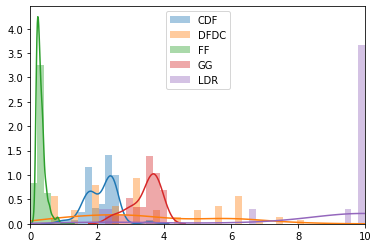

In [18]:


dtsets = np.unique(np.array(temp['dataset']))
for k in dtsets:
    
    cur_dur = np.array(temp[temp['dataset']==k][('duration', 'sum_minute')])
    cur_dur[cur_dur > 10] = 10
    sns.distplot(cur_dur, bins=np.linspace(0, 10, 50), label=k)

plt.xlim([0, 10])
plt.legend()
plt.show()

In [ ]:

display(duration_df[(duration_df['r_or_f']=='real')&(duration_df['dataset']=='LDR')].groupby(['label']).agg({'duration': 
                                                                                                             sum_minute}))


# plot the histogram

In [110]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

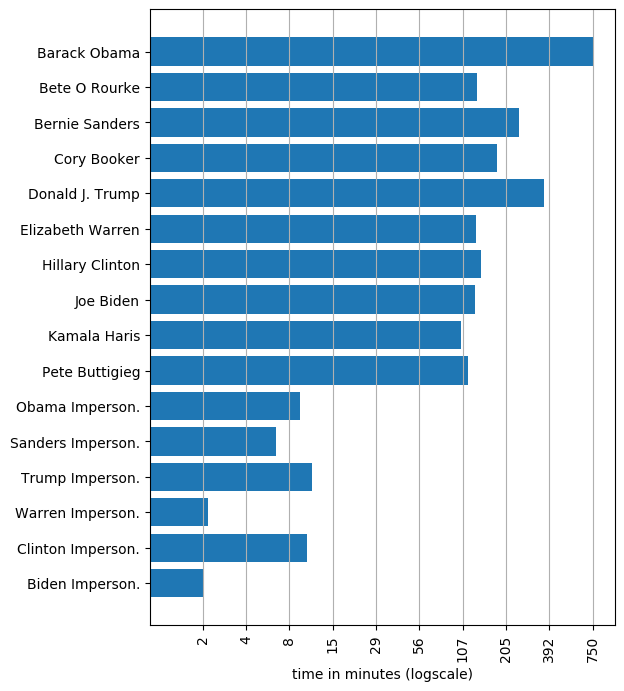

In [112]:

poi_names = ['Barack Obama', 'Bete O Rourke', 'Bernie Sanders', 
             'Cory Booker', 'Donald J. Trump', 'Elizabeth Warren', 
             'Hillary Clinton', 'Joe Biden', 'Kamala Haris', 'Pete Buttigieg', 
             'Obama Imperson.', 'Sanders Imperson.', 'Trump Imperson.', 
             'Warren Imperson.', 'Clinton Imperson.', 'Biden Imperson.']

durs = [750.1, 132.1, 248.0, 180.0, 364.5, 131.5, 140.3, 129.0, 104.6, 115.6, 
       9.5, 6.6, 11.3, 2.4, 10.4, 2.2]

log_dur = np.linspace(np.log10(np.min(durs)), np.log10(np.max(durs)), 10)

#poi_df = pd.DataFrame(data=poi_names, columns=['names'])
#poi_df['time(minutes)'] = durs.copy()

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6,8))

y_pos = np.arange(len(poi_names))
ax.barh(y_pos, np.log10(durs), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([r'{}'.format(x) for x in poi_names])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel(r'time in minutes (logscale)')
ax.set_xticks(log_dur)
ax.set_xticklabels([f'{np.power(10, x):.0f}' for x in log_dur], rotation=90)
ax.grid(b=True, axis='x')
plt.show()


# in wild dataset stats

In [11]:

# get all the identity specific train and test files for all available dataset
def get_files_per_dataset(bs_fldr):
    
    dataset = {}
    # IN wild
    dataset['inwild'] = {}
    dataset['inwild']['real'] = {}
    dataset['inwild']['fake'] = {}
    inwild_orig_allfiles = u.load_file_names(bs_fldr, 'inwild_orig', join_bsfldr=False)
    inwild_fake_allfiles = u.load_file_names(bs_fldr, 'inwild_fake', join_bsfldr=False)
    id_lbl = np.unique([f.split('/')[-1].split('_')[0] for f in inwild_orig_allfiles])  # get the unique ids
    for k in id_lbl:

        # current file label
        dataset['inwild']['real']['inwild_' + k] = [f for f in inwild_orig_allfiles if f.split('/')[-1].split('_')[0]==k]
        dataset['inwild']['fake']['inwild_' + k] = [f for f in inwild_fake_allfiles if f.split('/')[-1].split('_')[1]==k]
    
    dataset['inwild']['real']['steve_b'] = u.load_file_names(bs_fldr, 'steve_b', join_bsfldr=False)
    return dataset




In [12]:

dataset = get_files_per_dataset('/data/home/shruti/voxceleb/vgg/leaders/')


In [13]:
inwild_duration = print_per_data_stat(dataset)

inwild_orig/an_iyMo8ihXyCk_8.npy: 7.6 0.13
inwild_orig/an_Y4NtSOz8BxI_8.npy: 6.6 0.24
inwild_orig/an_iyMo8ihXyCk_17.npy: 6.7 0.35
inwild_orig/an_bATPXjOKebI_12.npy: 5.7 0.44
inwild_orig/an_w8TeV93Ji7M_14.npy: 7.1 0.56
inwild_orig/an_w8TeV93Ji7M_9.npy: 9.1 0.71
inwild_orig/an_Y4NtSOz8BxI_4.npy: 10.0 0.88
inwild_orig/an_iyMo8ihXyCk_22.npy: 7.9 1.01
inwild_orig/an_iyMo8ihXyCk_28.npy: 8.2 1.15
inwild_orig/an_w8TeV93Ji7M_3.npy: 9.4 1.31
inwild_orig/an_iyMo8ihXyCk_15.npy: 5.7 1.40
inwild_orig/an_Y4NtSOz8BxI_15.npy: 5.4 1.49
inwild_orig/an_iyMo8ihXyCk_24.npy: 5.7 1.59
inwild_orig/an_pJZToC7R0ko_2.npy: 5.6 1.68
inwild_orig/an_w8TeV93Ji7M_6.npy: 10.0 1.85
inwild_orig/an_w8TeV93Ji7M_15.npy: 7.3 1.97
inwild_orig/an_w8TeV93Ji7M_2.npy: 8.8 2.11
inwild_orig/an_w8TeV93Ji7M_20.npy: 9.3 2.27
inwild_orig/an_iyMo8ihXyCk_5.npy: 7.1 2.39
inwild_orig/an_bATPXjOKebI_24.npy: 5.1 2.47
inwild_orig/an_pJZToC7R0ko_8.npy: 5.4 2.56
inwild_orig/an_w8TeV93Ji7M_13.npy: 7.0 2.68
inwild_orig/an_iyMo8ihXyCk_34.npy: 6.7 2

inwild_orig/tc_mFKEl8ndLuI_29.npy: 30.8 9.54
inwild_orig/tc_FNNjLa1x1ag_3.npy: 25.1 9.96
inwild_orig/tc_tFgF1JPNR5E_2.npy: 8.0 10.09
inwild_orig/tc_mFKEl8ndLuI_65.npy: 6.1 10.20
inwild_orig/tc_LnVPaxFfZjQ_4.npy: 37.4 10.82
inwild_orig/tc_FNNjLa1x1ag_12.npy: 15.5 11.08
inwild_orig/tc_bKzA8wawl_M_16.npy: 6.9 11.19
inwild_orig/tc_bKzA8wawl_M_43.npy: 8.3 11.33
inwild_orig/tc_mH2-KTRYW1w_10.npy: 16.0 11.60
inwild_orig/tc_pX0oJVmLnmA_11.npy: 15.1 11.85
inwild_orig/tc_mFKEl8ndLuI_56.npy: 46.4 12.62
inwild_orig/tc_bKzA8wawl_M_61.npy: 39.2 13.28
inwild_orig/tc_mH2-KTRYW1w_1.npy: 21.4 13.63
inwild_orig/tc_P_1TZ4gYA2s_6.npy: 34.5 14.21
inwild_orig/tc_mFKEl8ndLuI_74.npy: 89.0 15.69
inwild_orig/tc_FNNjLa1x1ag_21.npy: 11.6 15.88
inwild_orig/tc_bKzA8wawl_M_25.npy: 7.8 16.01
inwild_orig/tc_JxtfVrfmYkk_13.npy: 7.2 16.13
inwild_orig/tc_3Q9cZsT8Zs0_4.npy: 7.5 16.26
inwild_orig/tc_Si4-VzckyWg_8.npy: 14.9 16.50
inwild_orig/tc_mFKEl8ndLuI_43.npy: 59.2 17.49
inwild_orig/tc_P_1TZ4gYA2s_11.npy: 87.8 18.95
inwi

inwild_orig/tc_bKzA8wawl_M_84.npy: 27.4 85.85
inwild_orig/tc_FNNjLa1x1ag_44.npy: 38.9 86.50
inwild_orig/tc_bKzA8wawl_M_48.npy: 5.2 86.58
inwild_orig/tc_mH2-KTRYW1w_15.npy: 22.3 86.95
inwild_orig/tc_tFgF1JPNR5E_52.npy: 14.7 87.20
inwild_orig/tc_FNNjLa1x1ag_26.npy: 8.7 87.34
inwild_orig/tc_FNNjLa1x1ag_62.npy: 18.4 87.65
inwild_orig/tc_mH2-KTRYW1w_6.npy: 30.8 88.17
inwild_orig/tc_tFgF1JPNR5E_16.npy: 7.7 88.29
inwild_orig/tc_FNNjLa1x1ag_68.npy: 11.6 88.49
inwild_orig/tc_P_1TZ4gYA2s_10.npy: 34.8 89.07
inwild_orig/tc_tFgF1JPNR5E_58.npy: 7.6 89.19
inwild_orig/tc_JxtfVrfmYkk_12.npy: 10.6 89.37
inwild_orig/tc_FNNjLa1x1ag_77.npy: 75.6 90.63
inwild_orig/tc_mFKEl8ndLuI_6.npy: 65.1 91.71
inwild_orig/tc_PEAkdmhTeH8_6.npy: 47.4 92.50
inwild_orig/tc_JxtfVrfmYkk_3.npy: 9.9 92.67
inwild_orig/tc_FNNjLa1x1ag_95.npy: 6.3 92.78
inwild_orig/tc_bKzA8wawl_M_99.npy: 11.9 92.97
inwild_orig/tc_bKzA8wawl_M_110.npy: 6.4 93.08
inwild_orig/tc_tFgF1JPNR5E_49.npy: 10.0 93.25
inwild_orig/tc_P_1TZ4gYA2s_1.npy: 25.1 93.67

In [14]:

# print the statistics
display(inwild_duration.groupby(['dataset', 'r_or_f']).agg({'fileName': ['count'], 'duration': [sum_minute]}))


fileName    duration
                  count  sum_minute
dataset r_or_f                     
inwild  fake          4    0.833333
        real        540  198.867222

In [15]:
temp = inwild_duration[inwild_duration['r_or_f']=='real'].groupby(['dataset', 'label']).agg({'duration': [sum_minute]}).reset_index()

temp[temp['dataset']=='inwild'].sort_values('label')

,dataset,label,duration
,,,sum_minute
0,inwild,inwild_an,2.792222
1,inwild,inwild_be,21.845556
2,inwild,inwild_bh,38.601111
3,inwild,inwild_tc,119.427778
4,inwild,steve_b,16.200556
